# Setup

Install in R:
```
install.packages("BiocManager")
BiocManager::install(c("edgeR", "BiocParallel", "RhpcBLASctl"))
```

Install

```pip install toytree ete4 pybiomart```

## Options & Data

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
import seaborn as sns
from scipy.sparse import issparse
from pymer4.models import lmer, lm, glmer, compare
from pymer4 import config
import polars
import statsmodels.api as sm
import senepy
import gseapy as gp
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import scflow
from scflow.ax import find_senescence_genes, run_senepy

# Display/Environment Settings
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.filterwarnings("ignore", message=".*ast.Ellipsis is deprecated.*")
config.PANDAS_BACKEND = True
warnings.filterwarnings("ignore", message=".*vert.*will be deprecated.*")
pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 300)
warnings.filterwarnings(
    "ignore", message="Bitwise inversion '~' on bool is deprecated",
    category=DeprecationWarning)

# Process Options
ncpus = os.cpu_count() - 1
overwrite = True

# If You Want Results Emailed (Will Overwrite HTML Regardless of `overwite`)
cur_file = os.path.join(os.path.abspath(""), "analyze_senescence_celltype"
                        "_specific_threshold_612.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Cell Type Label Column
col_celltype = "annotation_predicted_labels"
# col_celltype = "annotation_scanvi"
# col_celltype = "annotation_by_overlap"
# col_celltype = "Annotation_ToppGene"
# col_celltype = "cellmap_class_name"
# col_celltype = "cellmap_class_name_collapsed"
# use_hierarchy = False
collapse_neurons = True  # collapse neuron categories?
collapse_vascular = True

# Metadata Information
species = "Mouse"
col_condition = "Condition"
col_sample, col_batch = "sample", col_condition
# group_order = ["Ground Control | 12 Weeks", "Ground Control | 29 Weeks",
#                "Space Flight | 12 Weeks", "Space Flight | 29 Weeks"]
group_order = ["Ground Control", "Space Flight"]
keys = {col_condition: dict(key_control="Ground Control",
                            key_treatment="Space Flight"),
        col_batch: dict(key_control=group_order[0],
                        key_treatment=group_order[1])}
palette = {col_condition: {keys[col_condition]["key_control"]: "c",
                           keys[col_condition]["key_treatment"]: "tab:pink"},
           col_batch: {keys[col_condition]["key_control"]: "c",
                       keys[col_condition]["key_treatment"]: "tab:pink"}}

# Scoring Metrics
sen_metrics = ["senmayo"]
# sen_metrics = ["senepy", "senmayo"]
use_metric = "senmayo"
percentile = 1

# File Input & Output
file_path = "data/OSD-612_integrated.h5ad"
file_path_new = os.path.splitext(file_path)[0] + "_analyzed.h5ad"

# Load Data
self = scflow.Rna(file_path, col_sample=col_sample, col_batch=col_batch,
                  col_celltype=col_celltype)  # data
self.rna.obs.loc[:, col_batch] = self.rna.obs[col_batch].astype(
    pd.CategoricalDtype(categories=group_order, ordered=True))
self.rna = self.rna[:, self.rna.var.mt == False]  # snRNA-seq so remove MT-
self.rna = self.rna[:, self.rna.var.ribo == False]  # snRNA-seq so remove RB-
self.rna.obs.loc[:, "Spaceflight"] = (self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]).astype(int)  # 1 vs. 0 spaceflight
self.rna.X = self.rna.layers["log1p"].copy()
self.rna.raw = None

# Hierarchical
keys_cts = {"Neurons": ["Excitatory", "Inhibitory",
                        "Gabaergic", "Dopaminergic", "Serotonergic",
                        "Excitatory-Inhibitory", "Neuron"],
            "Macroglia": ["Oligodendrocyte", "OPC", "Astrocyte",
                          "Tanycyte", "Ependymal", "Glia"],
            "Microglia": ["Microglial"],
            "Neurovascular": ["Endothelial", "Vascular", "Pericyte"]}
key_cts = dict(pd.concat([pd.Series(dict(([(i, x) for i in keys_cts[
    x]]))) for x in keys_cts]))
self.rna.obs.loc[:, f"{col_celltype}_collapsed"] = self.rna.obs[
    col_celltype].copy()
if collapse_neurons is True:
    self.rna.obs.loc[:, f"{col_celltype}_collapsed"] = self.rna.obs[
        f"{col_celltype}_collapsed"].replace(dict(zip(
            keys_cts["Neurons"], ["Neuron"] * 3)))
    col_celltype = f"{col_celltype}_collapsed"
    self.col_celltype = col_celltype
if collapse_vascular is True:
    self.rna.obs.loc[:, f"{col_celltype}_collapsed"] = self.rna.obs[
        f"{col_celltype}_collapsed"].replace(dict(zip(keys_cts[
            "Neurovascular"], ["Vascular"] * 3)))
    col_celltype = f"{col_celltype}_collapsed"
    self.col_celltype = col_celltype
self.rna.obs.loc[:, f"{col_celltype}_hierarchy"] = self.rna.obs[
    col_celltype].replace(key_cts)

# Display Object
print(self.rna)
print(self.rna.obs.groupby(col_sample).describe())
self.rna.obs

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/senepy/load_hubs.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  __version_info__ = tuple(LooseVersion(__version__).version)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/fields.py:198: RemovedInMarshmallow4Warning: Passing field metadata as a keyword arg is deprecated. Use the explicit `metadata=...` argument instead.
  warnings.warn(


## Data Descriptives

In [ ]:
%matplotlib inline

# Detect Metadata Columns in AnnData Object
metadata_cols = self.rna.obs.groupby(col_sample).apply(
    lambda x: list(x.columns[np.where(
        x.apply(lambda y: len(y.unique()) ==  1))[0]]))
metadata_cols = [x for x in metadata_cols.explode().unique() if all((
    x in metadata_cols.loc[i] for i in metadata_cols.index.values))]

# Value Counts for Categorical Variables
metadata_cols_category = self.rna.obs[metadata_cols].dtypes[((
    self.rna.obs[metadata_cols].dtypes == "category") | (self.rna.obs[
        metadata_cols].apply(lambda x: len(x.unique()) < 6))) & (self.rna.obs[
            metadata_cols].apply(lambda x: len(x.unique()) > 1))].index
for x in metadata_cols_category:
    print(x, "\n\n", self.rna.obs[x].value_counts(), "\n\n")
    if col_batch is not None:  # by batch
        if x != col_batch:
            print(x, "\n\n", self.rna.obs[[x, col_batch]].groupby(
                col_batch).value_counts(), "\n\n")

# Descriptives for Continuous Variables
print(self.rna.obs[self.rna.obs.columns.difference(
    metadata_cols_category)].describe())
if col_batch is not None:  # by batch
    print(self.rna.obs[list(self.rna.obs.columns.difference(
        metadata_cols_category)) + [col_batch]].groupby(col_batch).describe())

# Cells per Cluster
perc_clusters = round(100 * self.rna.obs.groupby(col_sample).value_counts(
    [col_celltype], normalize=True).unstack(1), 2)
print(f"\n\n*** Cell Composition (%) ***\n\n{perc_clusters}")

# Number of Cells
n_cells = self.rna.obs.groupby(col_sample).apply(
    lambda x: x.n_cells_original_sample.unique()[0],
    include_groups=False).to_frame("Original Cell N").join(
        self.rna.obs.groupby(col_sample).apply(
            lambda x: x.shape[0], include_groups=False).to_frame("N Cells"))
n_cells.loc[:, "Percent_Filtered"] = round(100 * (1 - n_cells[
    "N Cells"] / n_cells["Original Cell N"]), 2)
print("\n\n", n_cells.sort_values("Percent_Filtered"))

/tmp/ipykernel_745482/1416146960.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata_cols = self.rna.obs.groupby(col_sample).apply(


Group 

 Group
Ground Control    33095
Space Flight      29231
Name: count, dtype: int64 


Group 

 Condition       Group         
Ground Control  Ground Control    33095
                Space Flight          0
Space Flight    Space Flight      29231
                Ground Control        0
Name: count, dtype: int64 


sample 

 sample
RR10_BRN_GC_WT_G3     12739
RR10_BRN_FLT_WT_F1     9930
RR10_BRN_FLT_WT_F3     9550
RR10_BRN_GC_WT_G1      6826
RR10_BRN_GC_WT_G9      6823
RR10_BRN_FLT_WT_F7     3994
RR10_BRN_GC_WT_G5      3609
RR10_BRN_GC_WT_G7      3098
RR10_BRN_FLT_WT_F9     2924
RR10_BRN_FLT_WT_F5     2833
Name: count, dtype: int64 


sample 

 Condition       sample            
Ground Control  RR10_BRN_GC_WT_G3     12739
                RR10_BRN_GC_WT_G1      6826
                RR10_BRN_GC_WT_G9      6823
                RR10_BRN_GC_WT_G5      3609
                RR10_BRN_GC_WT_G7      3098
                RR10_BRN_FLT_WT_F1        0
                RR10_BRN_FLT_WT_F3        0


## Remove Cell Types Not in All Samples

In [ ]:
ct_cts = self.rna.obs.groupby(col_sample).value_counts([
    col_celltype]).unstack(1).replace(np.nan, 0)
cts_in_all_samples = ct_cts.apply(lambda x: all(x > 1)).replace(
    False, np.nan).dropna().index.values
drop_cts = set(self.rna.obs[col_celltype]).difference(cts_in_all_samples)
ct_cts
if len(drop_cts) > 0:
    print(f"\nDropping cell types not present in all samples: {drop_cts}\n\n")
    self.rna = self.rna[self.rna.obs[col_celltype].isin(cts_in_all_samples)]
ct_cts


Dropping cell types not present in all samples: {'Lymphoid', 'Inhibitory | Excitatory', 'Monocyte', 'Dopaminergic', 'Macrophage', 'Ependymal'}




annotation_predicted_labels,Excitatory,Inhibitory,Inhibitory | Excitatory,Dopaminergic,Astrocyte,Ependymal,OPC,Oligodendrocyte,Vascular,Pericyte,Endothelial,Microglia,Macrophage,Monocyte,Lymphoid
sample,,,,,,,,,,,,,,,
RR10_BRN_GC_WT_G5,2151,570,0,13,263,0,109,362,63,11,11,53,1,0,2
RR10_BRN_FLT_WT_F1,2966,4022,4,0,901,1,312,1469,39,22,29,161,2,0,2
RR10_BRN_GC_WT_G1,4365,1005,0,19,512,0,141,668,46,7,6,53,2,0,2
RR10_BRN_GC_WT_G9,4469,1041,0,0,524,0,163,455,59,19,22,56,3,0,12
RR10_BRN_FLT_WT_F3,5763,1619,0,55,763,0,234,930,52,15,12,99,6,0,2
RR10_BRN_GC_WT_G3,2928,6880,5,0,991,8,307,1295,118,34,16,143,1,0,13
RR10_BRN_FLT_WT_F7,2163,583,5,0,416,2,83,627,20,16,30,42,1,1,5
RR10_BRN_FLT_WT_F9,1506,617,0,0,298,8,96,276,63,6,8,43,3,0,0
RR10_BRN_FLT_WT_F5,1046,886,0,0,274,4,80,423,36,18,6,58,2,0,0


## Get Marker Gene Sets

From Google Drive, except senmayo derived from file downloaded from
https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/SAUL_SEN_MAYO.html
then created using:

```
from pybiomart import Server

senmayo = pd.read_csv("resources/SAUL_SEN_MAYO.v2025.1.Hs.tsv",
                      sep="\t", header=0)
senmayo = senmayo[senmayo.STANDARD_NAME == "GENE_SYMBOLS"]
senmayo = pd.Series({"Senmayo": senmayo.iloc[0, 1].split(
    ",")}, name="symbol").rename_axis("Gene_Set").explode().str.strip(
        ).replace("", np.nan).dropna().to_frame()
server = Server(host="http://www.ensembl.org")
mart = server.marts["ENSEMBL_MART_ENSEMBL"] # Access the Ensembl mart
human_dataset = mart.datasets["hsapiens_gene_ensembl"]
orthologs = human_dataset.query(attributes=[
    "external_gene_name", "mmusculus_homolog_associated_gene_name"])
orthologs = orthologs.dropna().set_index(orthologs.columns[0])
orthologs = orthologs.loc[orthologs.index.intersection(
    senmayo.symbol.to_list())].iloc[:, 0]
print(f"{orthologs.shape[0]} orthologs found out of"
      f" {len(senmayo.symbol.unique())} senmayo genes")
senmayo = senmayo.assign(symbol=senmayo.replace({"symbol": dict(zip(
    orthologs.index, orthologs.values))}))
senmayo.to_csv("gene_sets/senmayo.csv")
```

(Also could use `scflow.tl.convert_gene_species(senmayo.symbol.to_list())`)

Certain gene sets created from Google Drive ADBR AWG > Projects > White Matter > Gene Sets files (with the suffix = "_adjusted") were modified for consistency, e.g.,

```
pd.read_csv("gene_sets/_iron_genes_gmt_out.csv", index_col=[
    0, 1]).rename_axis(["row_id", "pathway"]).stack().to_frame(
        "symbol").reset_index(-1, drop=True).reset_index().to_csv(
            "gene_sets/_iron_genes_gmt_out_adjusted.csv")
```


### *A Priori*

In [ ]:
mks = [pd.read_csv(os.path.join("gene_sets", i)).dropna(
    how="all", axis=1).assign(Source_File=i) for i in os.listdir("gene_sets")]
mks = [x.assign(Gene_Set=x["Source_File"].iloc[0].split("_2025")[0]) if (
    "pathway" in x) else x for x in mks]
mks = pd.concat(mks).drop("Unnamed: 0", axis=1).drop("row_id", axis=1)
mks = mks[mks.symbol.isin(self.rna.var_names)]
mks = mks[["Gene_Set", "symbol"]].set_index("Gene_Set").groupby(
    "Gene_Set").apply(lambda x: x["symbol"].to_list())
marker_genes_dict = dict(mks)
marker_gene_sets = mks.copy()
print(marker_gene_sets)

Gene_Set
GOBP_CELLULAR_RESPONSE_TO_IRON_ION                                                                                                                                                                                                               [B2m, Bmp6, Gpld1, Hfe, Ireb2, Tfr2, Tfrc, Trf]
GOBP_CENTRAL_NERVOUS_SYSTEM_MYELIN_FORMATION                                                                                                                                                                                                      [Abca2, Ckap5, Cntn1, Ercc2, Mag, Mios, Tenm4]
GOBP_INTRACELLULAR_IRON_ION_HOMEOSTASIS                                                                                                                                                      [Abcb7, Aco1, Alas2, Atp13a2, Atp6ap1, Atp6v0a2, Atp6v0d1, Atp6v1a, Atp6v1g1, B2m, Bmp6, Bmyc, B...
GOBP_IRON_COORDINATION_ENTITY_TRANSPORT                                                                                     

### Clusters in Data

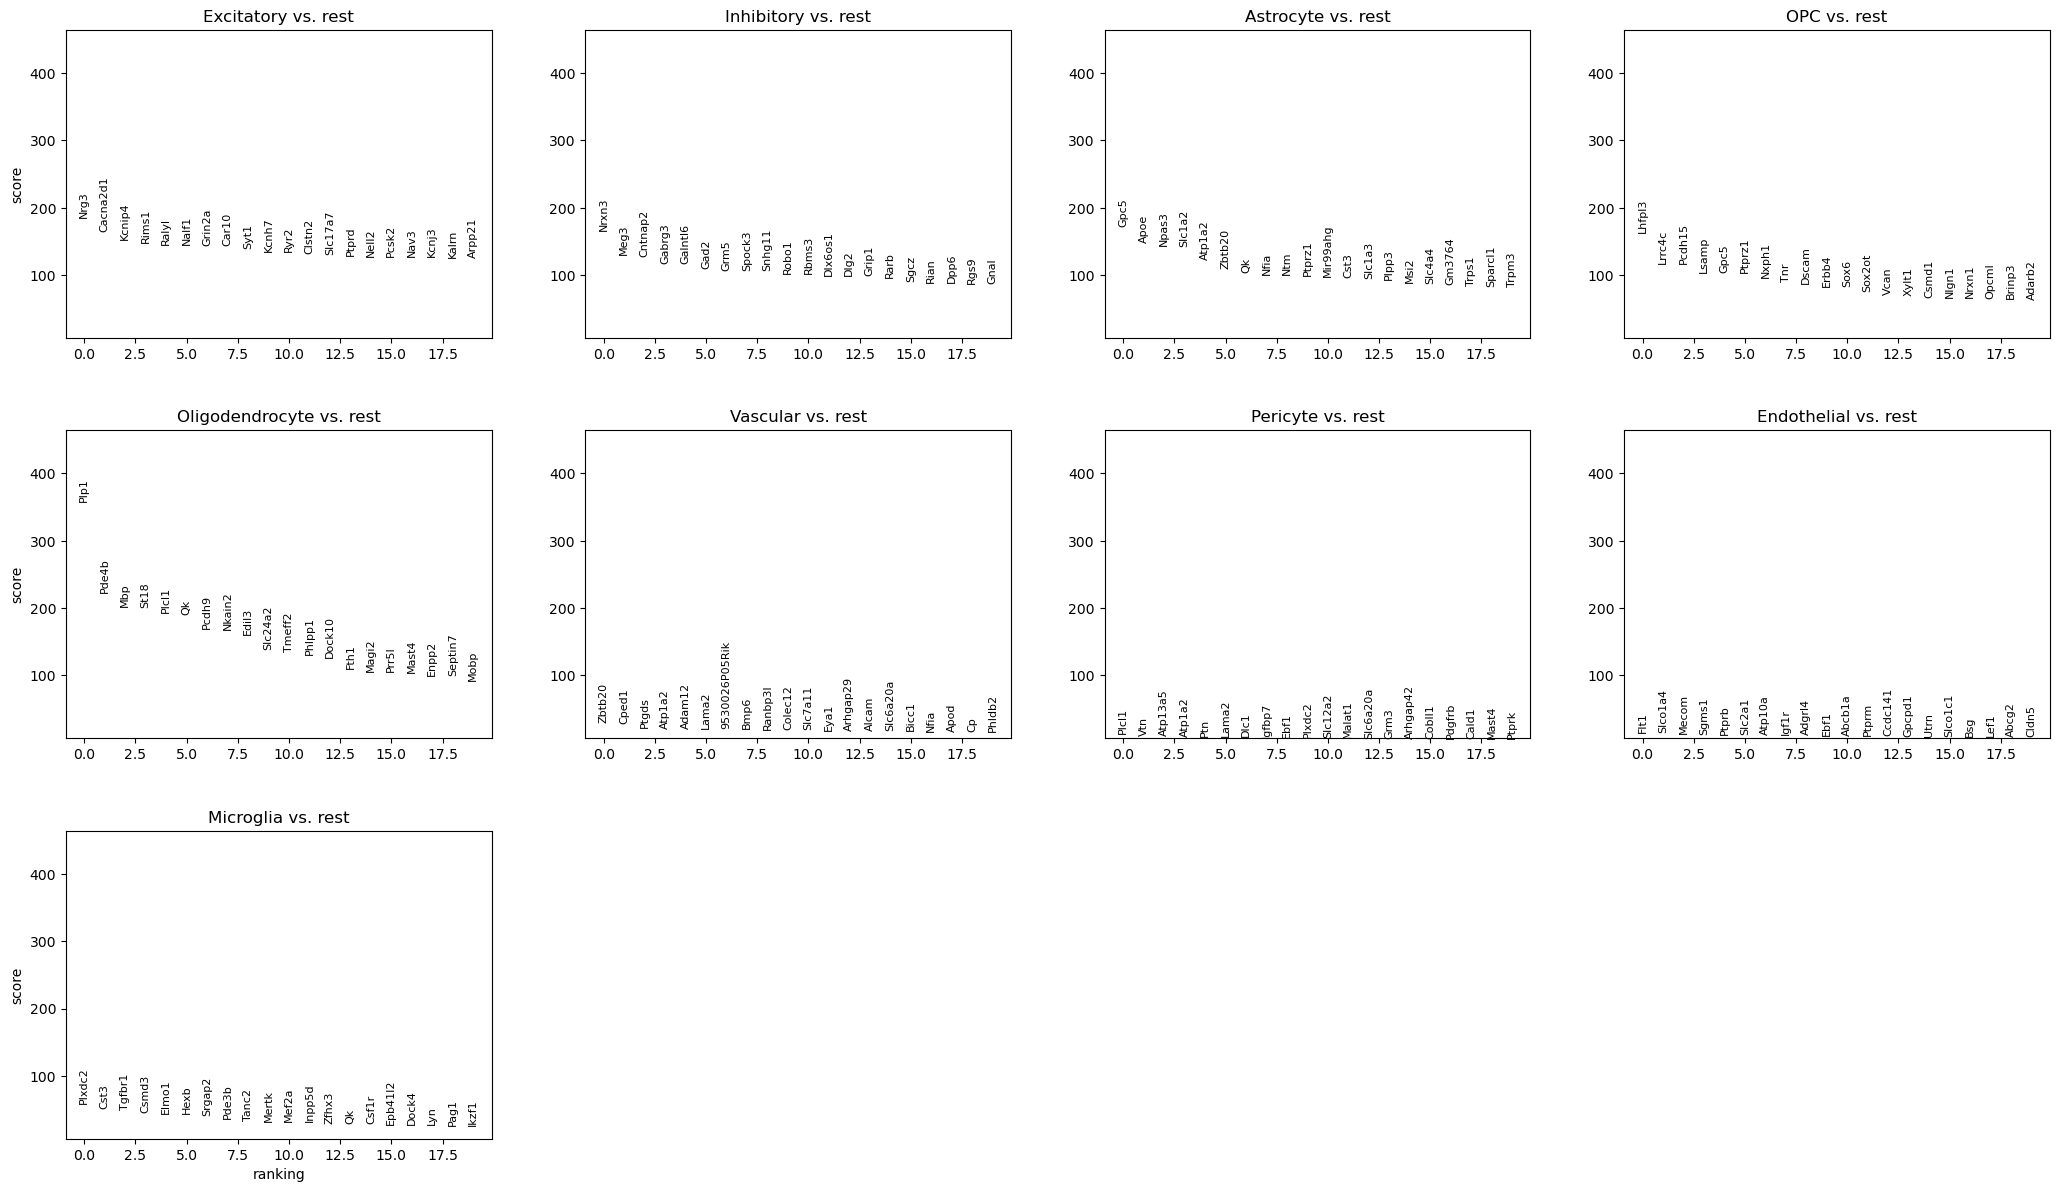

scores  logfoldchanges          pvals      pvals_adj
annotation_predicted_labels annotation_predicted_labels names                                                                  
Astrocyte                   Astrocyte                   Gpc5           171.695572        6.539733   0.000000e+00   0.000000e+00
                                                        Apoe           148.374893        5.237165   0.000000e+00   0.000000e+00
                                                        Sparcl1         83.055389        3.822330   0.000000e+00   0.000000e+00
Endothelial                 Endothelial                 Flt1            15.164124       10.314817   3.771032e-32   1.028051e-31
                                                        Slco1a4         14.426362       10.401313   3.312484e-30   8.784430e-30
                                                        Mecom           12.955082        8.836013   2.766054e-26   6.895904e-26
Excitatory                  Excitatory                  A830082K12Rik   48.399384        1.441985   0.000000e+00   0.000000e+00
                                                        Epha3           47.215202        1.248798   0.000000e+00   0.000000e+00
                                                        Rtn4rl1         47.502010        1.737795   0.000000e+00   0.000000e+00
Inhibitory                  Inhibitory                  Nrxn3          165.992050        2.527063   0.000000e+00   0.000000e+00
                                                        Meg3           130.896667        2.012453   0.000000e+00   0.000000e+00
                                                        Cntnap2        126.734154        2.268783   0.000000e+00   0.000000e+00
Microglia                   Microglia                   Plxdc2          58.591362        4.615034  1.338881e-281  8.472361e-279
                                                        Cst3            51.081848        4.600204  1.579043e-245  3.904956e-243
                                                        Tgfbr1          49.507099        6.955161  3.007529e-236  5.991388e-234
OPC                         OPC                         Lhfpl3         163.683578        5.433758   0.000000e+00   0.000000e+00
                                                        Lrrc4c         117.773750        2.653126   0.000000e+00   0.000000e+00
                                                        Pcdh15         116.616837        4.053491   0.000000e+00   0.000000e+00
Oligodendrocyte             Oligodendrocyte             Aspa            66.789948        5.367509   0.000000e+00   0.000000e+00
                                                        Gatm            65.642166        4.586073   0.000000e+00   0.000000e+00
                                                        Car2            65.290489        4.496396   0.000000e+00   0.000000e+00
Pericyte                    Pericyte                    Plcl1           14.208226        3.373029   4.508868e-30   1.624114e-29
                                                        Vtn             10.400340        8.421688   1.259371e-19   3.652158e-19
                                                        Atp13a5         10.156939        6.619927   5.714486e-19   1.636895e-18
Vascular                    Vascular                    Zbtb20          29.278393        2.574851  1.893517e-112  1.711723e-110
                                                        Cped1           28.764418        7.540332  4.411677e-109  3.541688e-107
                                                        Ptgds           22.268000        4.346749   1.898909e-77   6.820540e-76

In [ ]:
self.find_markers(col_celltype=col_celltype)
df_celltype_markers = self.get_markers_df(
    n_genes=50, col_celltype=col_celltype,
    log2fc_threshold=1, p_threshold=1e-10)
df_celltype_markers.groupby(col_celltype).apply(lambda x: x.head(3))

# Score Senescence

## Run Scoring

If you want just to find the senescence-related genes, run:

```
tissue = "Brain"  # or whatever you want here
celltype = None  # or whatever you want here
genes_senepy, hubs, figs = find_senescence_genes(
    self.rna, species=species, tissue=tissue, celltype=celltype,
    overlap_threshold=0, literature_sources=None,
    sengpt_sources=True, plot=True, col_celltype=col_celltype
)  # find tissue- and/or cell type-specific genes
```

To see available hubs:

```
hubs = senepy.load_hubs(species=species)
hubs.metadata.set_index(["tissue", "cell"]).sort_index()
```

Other examples of arguments you could use:

```
# tissue = ["Brain", "Myeloid"]
# tissue = None

# celltype = "GABA interneuron"  # only human I think
# celltype = ["microglia", "t cell", "monocyte"]
# celltype = "microglia"
# celltype = "microglial cell"`

### Senepy

In [ ]:
%%time

tissue = "Brain"
celltype = None  # use all cell types

if "senepy" in sen_metrics:
    self.rna.X = self.rna.layers["log1p"].copy()
    self.rna, genes_senepy, figs = run_senepy(
        self.rna, species=species, tissue=tissue, celltype=celltype,
        overlap_threshold=0, literature_sources=None,
        sengpt_sources=True, col_celltype=col_celltype,
        col_senscore="score_senepy", identifiers=[col_celltype],
        use_translator=True, plot=True, figsize=(20, 20),
        swap_axes=False, standard_scale="group", plot_layer="log1p"
    )  # find tissue- and/or cell type-specific genes
    self.rna.obs.loc[
        :, "score_senepy_original_scale"] = self.rna.obs.score_senepy
    self.rna.obs.loc[:, "score_senepy"] = np.log(
        self.rna.obs.score_senepy)  # log-transform senescence score
    self.rna.obs[["score_senepy"]]

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 5.96 μs


### Senmayo

In [ ]:
if "senmayo" in sen_metrics:
    sc.tl.score_genes(self.rna, marker_gene_sets.loc["Senmayo"],
                      ctrl_as_ref=True, ctrl_size=50, gene_pool=None,
                      n_bins=25, score_name="score_senmayo", random_state=0,
                      copy=False, layer="log1p", use_raw=False)

## Label SnCs

### Define Snc Threshold & Label Cells

Based on percentile threshold derived from control group

In [ ]:
# Determine Threshold
perc_s, perc = str(100 - percentile) + "%", 1 - (percentile / 100)
p_h = 3
perc_s_h, perc_h = str(100 - p_h) + "%", 1 - (p_h / 100)
print("Percentile for Threshold:", perc_s)
for u in sen_metrics:
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc])[perc_s], include_groups=False).to_frame(
                    f"Senescence_Threshold_{u}"), on=col_celltype).loc[
                        self.rna.obs.index]
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc_h])[perc_s_h],
                                include_groups=False).to_frame(
                                    f"Senescence_Threshold_{u}_{p_h}"),
                                on=col_celltype).loc[self.rna.obs.index]

# Binary CLassification
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_{x}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}"])
    self.rna.obs.loc[:, f"Senescent_Cell_{x}_{p_h}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}_{p_h}"])

# String Labels (for Plotting/Categorical Analysis)
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_{x}_{p_h}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_by_Type_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype].astype(str)
    self.rna.obs.loc[:, f"SnC_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype + "_hierarchy"].astype(str)

# Descriptives
for x in sen_metrics:
    print(x, round(self.rna.obs[[
        f"Senescent_Cell_Label_{x}", col_celltype]].value_counts(
            normalize=True).sort_index() * 100, 1).unstack(0))

# Choose Metrics for Main Analysis
for x in ["Senescent_Cell_Label", "Senescent_Cell", "SnC_hierarchy",
            "Senescence_Threshold", "Senescent_Cell_Label_by_Type"]:
    self.rna.obs.loc[:, x] = self.rna.obs[f"{x}_{use_metric}"]
self.rna.obs.loc[:, "senscore"] = self.rna.obs[f"score_{use_metric}"]
self.rna.obs.loc[
    :, f"Senescent_Cell_Label_by_Type_{use_metric}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_Label_{use_metric}_{p_h}"].replace({
            "Non-Senescent": "", "Senescent": "SnC "}).astype(
                str) + self.rna.obs[
                    col_celltype].astype(str)  # lower threshold SnC by type
genes = marker_gene_sets.loc["Senmayo"] if (
    use_metric == "senmayo") else genes_senepy  # main senescence gene list

# Avoid Nesting Duplication Issues
self.rna.obs.loc[:, "SnC_hierarchy"] = self.rna.obs[
    "SnC_hierarchy"].replace({
        "Neuron": "Neurons", "SnC Neuron": "SnC Neurons"})

Percentile for Threshold: 99%
senmayo Senescent_Cell_Label_senmayo  Non-Senescent  Senescent
annotation_predicted_labels                           
Excitatory                             45.3        0.4
Inhibitory                             29.5        0.2
Astrocyte                               8.3        0.1
OPC                                     2.6        0.0
Oligodendrocyte                        10.9        0.1
Vascular                                0.8        0.0
Pericyte                                0.3        0.0
Endothelial                             0.2        0.0
Microglia                               1.2        0.0


### Label Batch/Cell-Specific Senescence Percentiles

In [ ]:
# for x in ["Senescence_Label", "Senescence_CellType"]:
#     if x in self.rna.obs:
#         self.rna.obs = self.rna.obs.drop(x, axis=1)

# # %ile Thresholds (Overall)
# thresh = self.rna.obs["score_senepy"].describe(
#     percentiles=[0.90, 0.95, 0.99])
# thres_ct =  self.rna.obs[["score_senepy", col_celltype]].groupby(
#     col_celltype).describe(percentiles=[0.90, 0.95, 0.99])["score_senepy"]

# sen = self.rna.obs["score_senepy"].apply(
#     lambda x: "Top 1%" if x >= float(thresh.loc["99%"]) else "Top 5%" if (
#         x >= float(thresh.loc["95%"])) else "Top 10%" if x >= float(
#             thresh.loc["90%"]) else "Bottom 90%").to_frame(
#                 "Senescence_Label").loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sen).loc[self.rna.obs.index]

# # %ile Thresholds (by Cell Type)
# sct = self.rna.obs.groupby(
#     col_celltype).apply(lambda g: g["score_senepy"].apply(
#         lambda x: f"Top 1% {g.name}" if x >= float(thres_ct.loc[g.name][
#             "99%"]) else f"Top 5% {g.name}" if (x >= float(thres_ct.loc[
#                 g.name]["95%"])) else f"Top 10% {g.name}" if x >= float(
#                     thres_ct.loc[g.name]["90%"]) else g.name),
#                         include_groups=False)

# sct = sct.to_frame("Senescence_CellType").reset_index(0, drop=True)
# sct = sct.loc[self.rna.obs.index]
# self.rna.obs = self.rna.obs.join(sct).loc[self.rna.obs.index]

# for x in ["Senescence_Label", "Senescence_CellType"]:
#     self.rna.obs = self.rna.obs.assign(**{
#         x: self.rna.obs[x].astype("category")})

# high_sen_cts = [i for i in self.rna.obs["Senescence_CellType"].unique(
#     ) if " 1% " in i]

### Descriptives of SnCs

Percent Senescent: 

 Senescent_Cell                       0                                                                                              1                                                                                   
annotation_predicted_labels Excitatory Inhibitory Astrocyte    OPC Oligodendrocyte Vascular Pericyte Endothelial Microglia Excitatory Inhibitory Astrocyte   OPC Oligodendrocyte Vascular Pericyte Endothelial Microglia
Condition                                                                                                                                                                                                               
Ground Control                   99.00      98.99     98.99  98.90           99.00    98.68    98.78       98.51     98.79       1.00       1.01      1.01  1.10            1.00     1.32     1.22        1.49      1.21
Space Flight                     99.15      99.48     99.25  99.63           99.44    98.57    97.40       96.

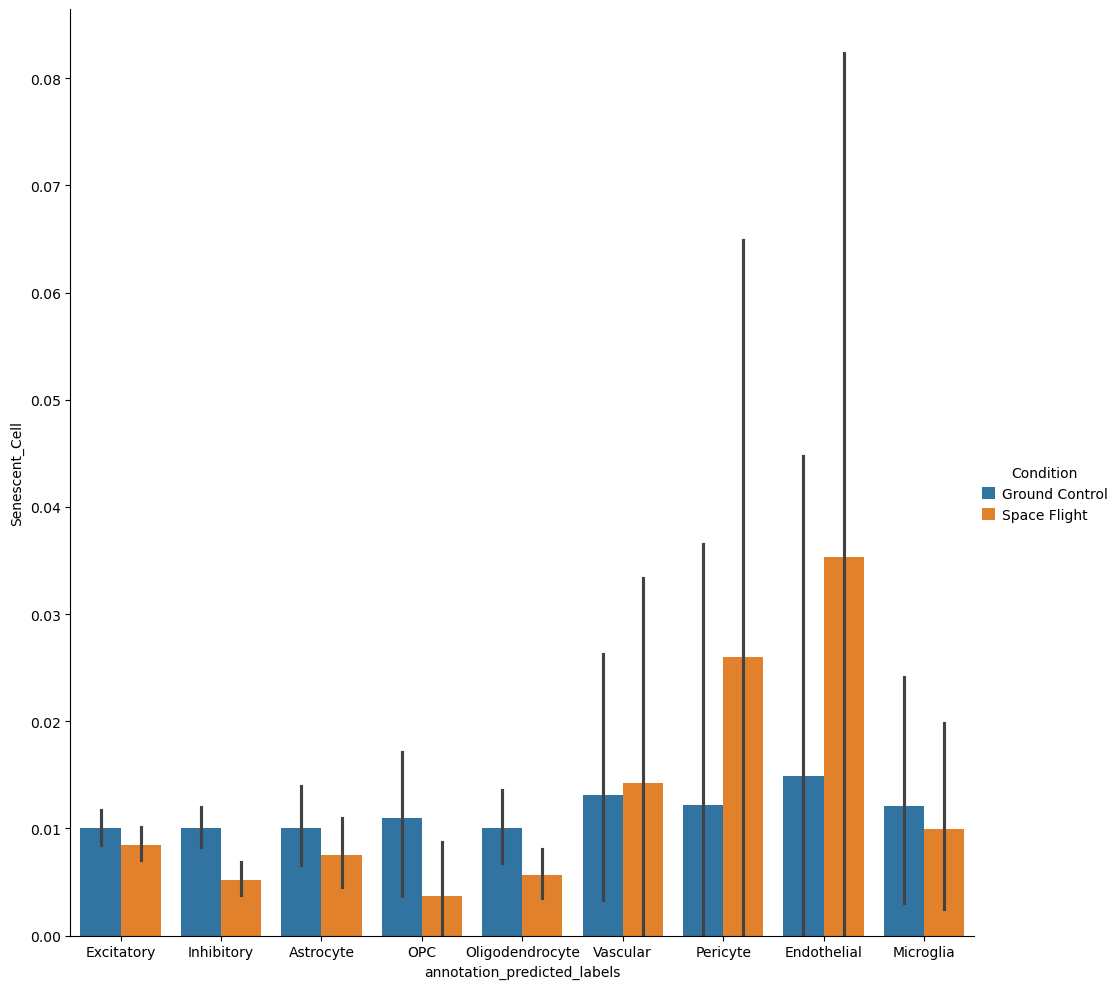

In [ ]:
print("Percent Senescent: \n\n", round(self.rna.obs.groupby([
    col_celltype, col_batch]).apply(lambda x: x["Senescent_Cell"].astype(
        int).value_counts(normalize=True), include_groups=False) * 100,
    2).unstack(col_celltype))
sns.catplot(self.rna.obs, y="Senescent_Cell", x=col_celltype,
            hue=col_batch, kind="bar", height=10)

# SnC DEGs

## Overall

... storing 'Senescent_Cell_Label_senmayo' as categorical
... storing 'Senescent_Cell_Label_hierarchy_senmayo' as categorical
... storing 'Senescent_Cell_Label_senmayo_3' as categorical
... storing 'Senescent_Cell_Label_by_Type_senmayo' as categorical
... storing 'SnC_hierarchy_senmayo' as categorical
... storing 'Senescent_Cell_Label' as categorical
... storing 'SnC_hierarchy' as categorical
... storing 'Senescent_Cell_Label_by_Type' as categorical
... storing 'Senescent_Cell_Label_by_Type_senmayo_3' as categorical


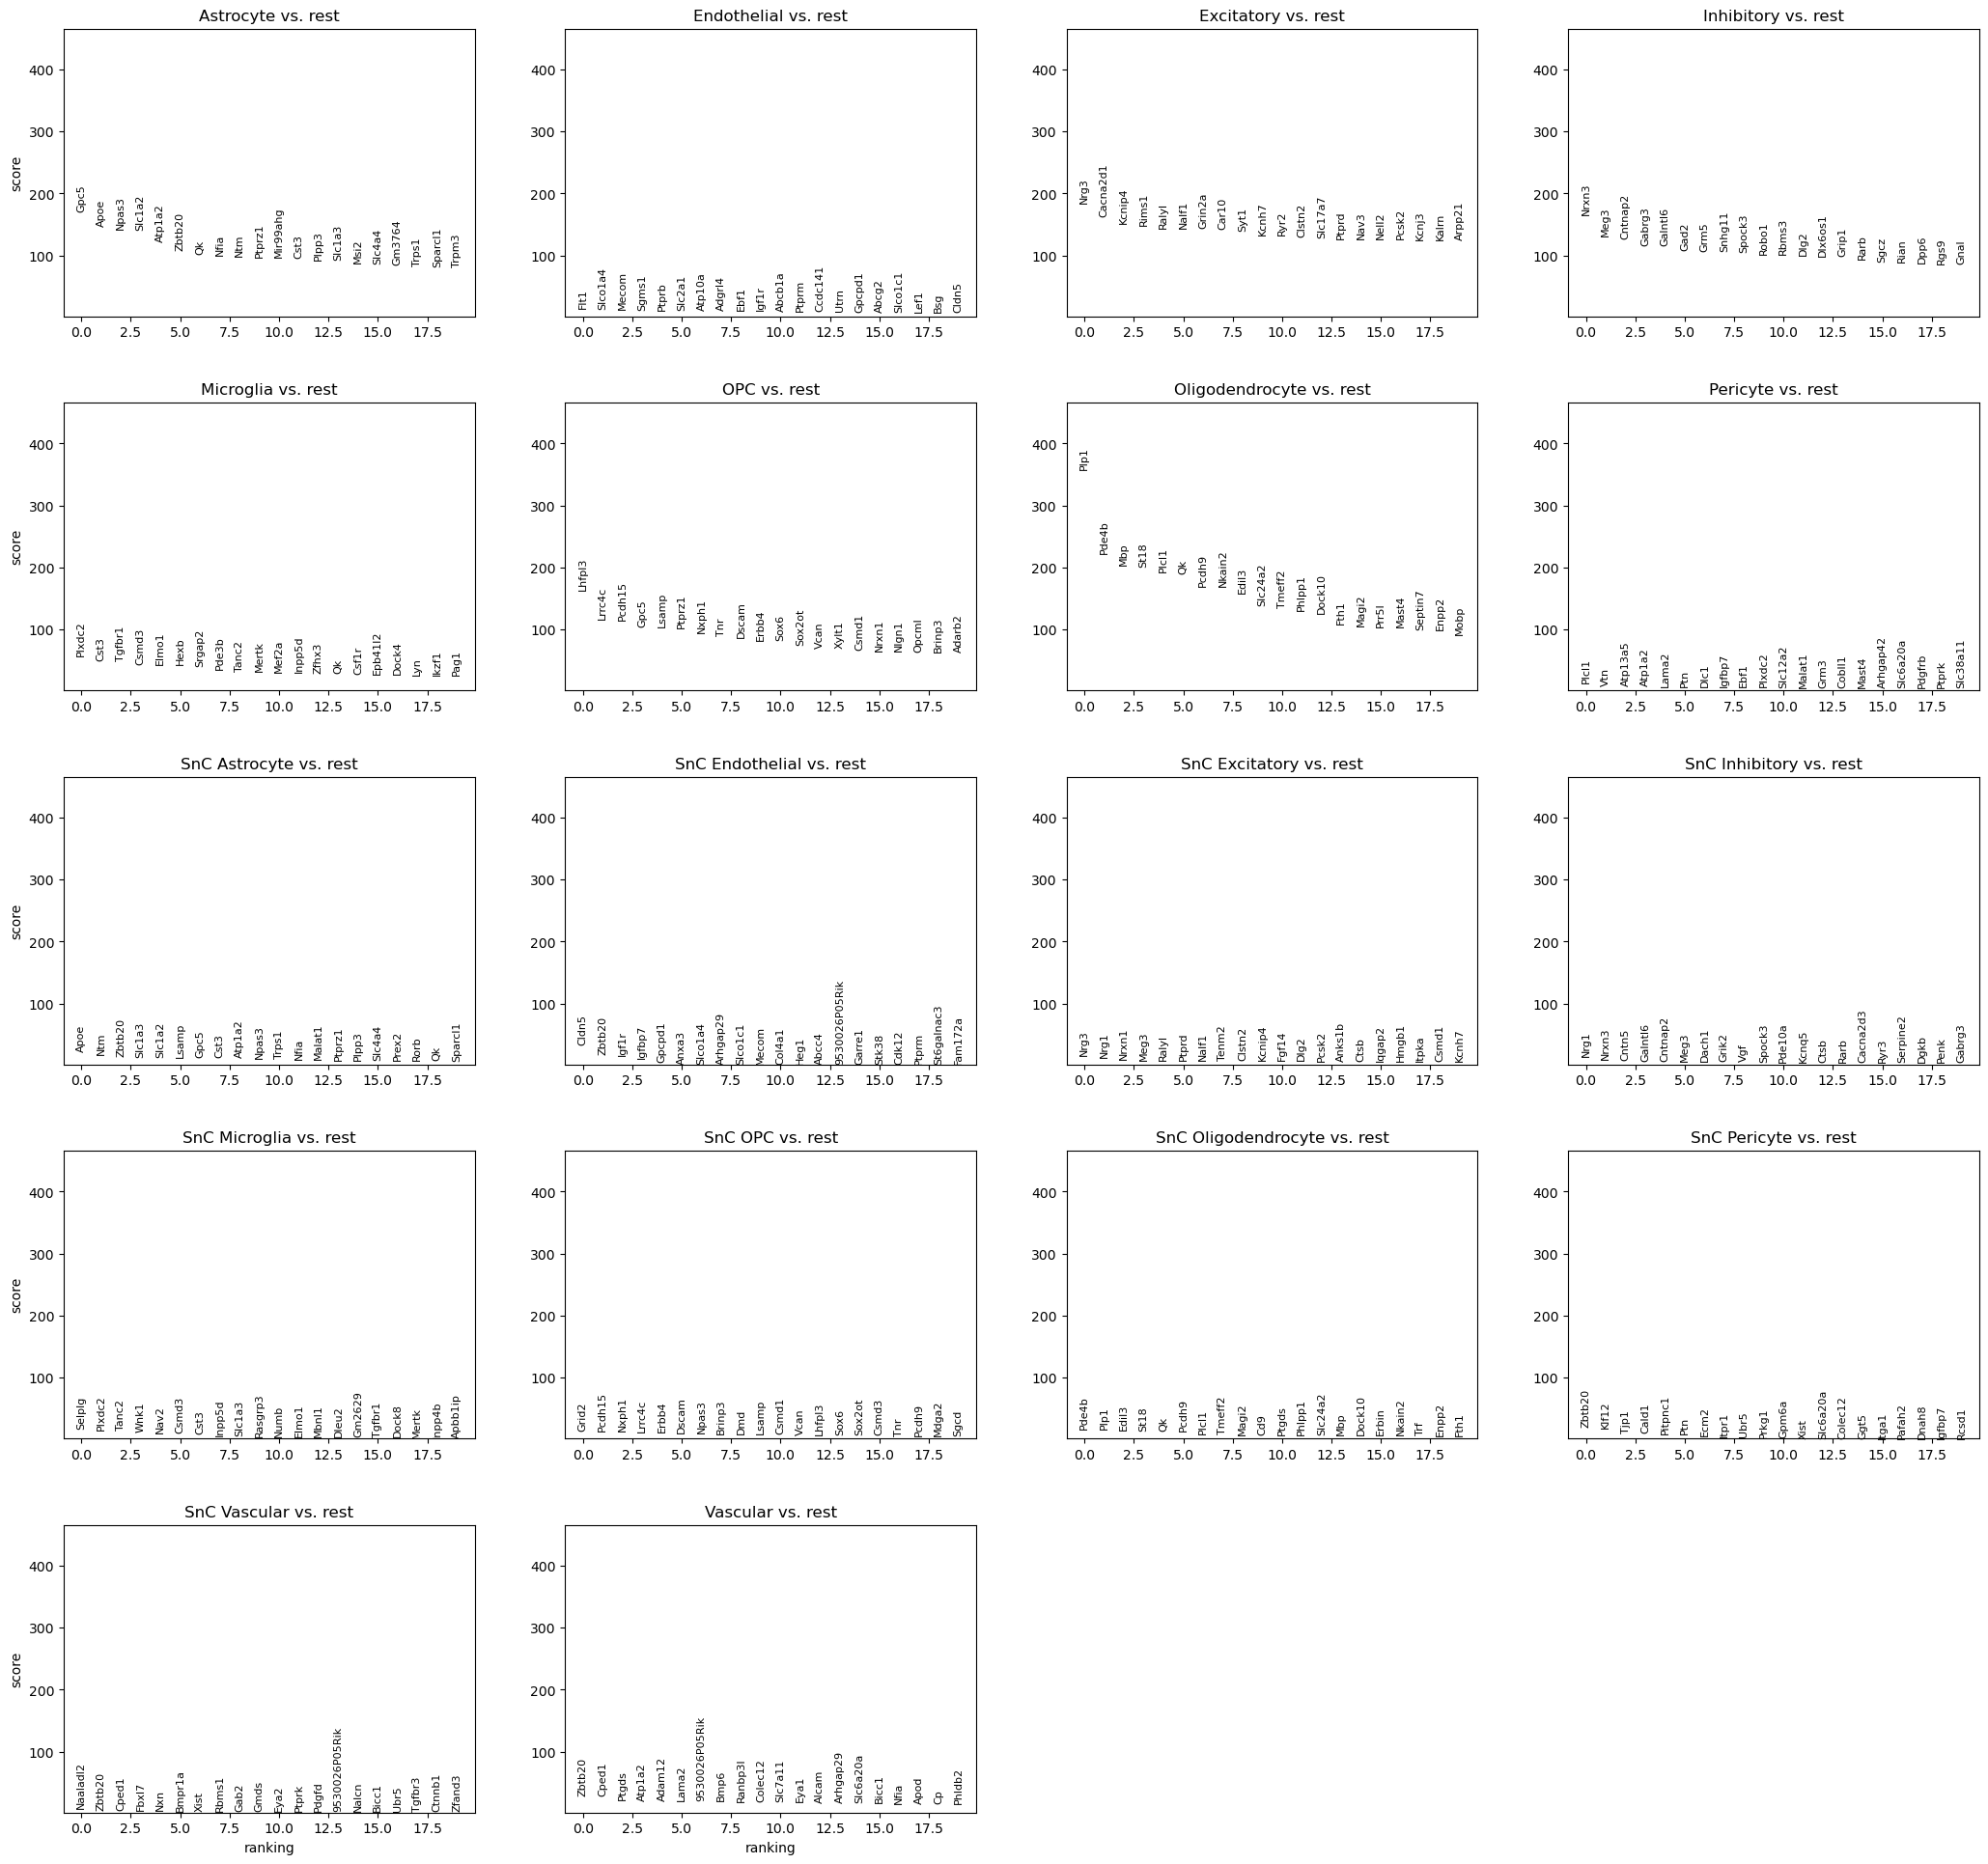

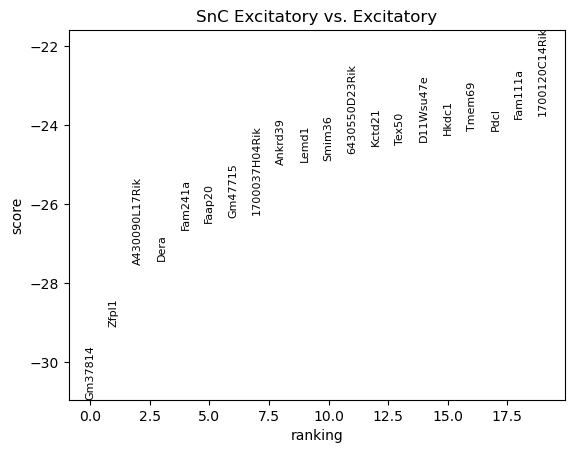

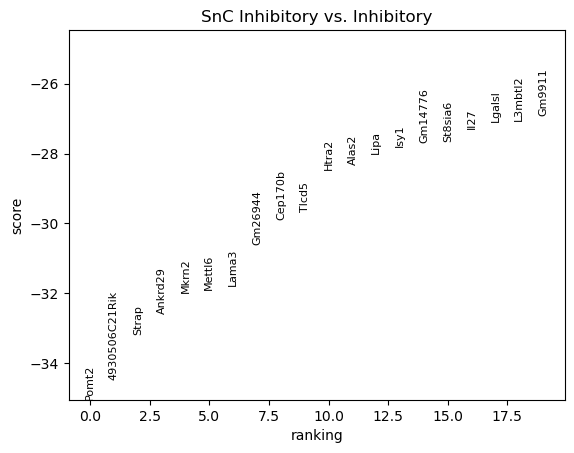

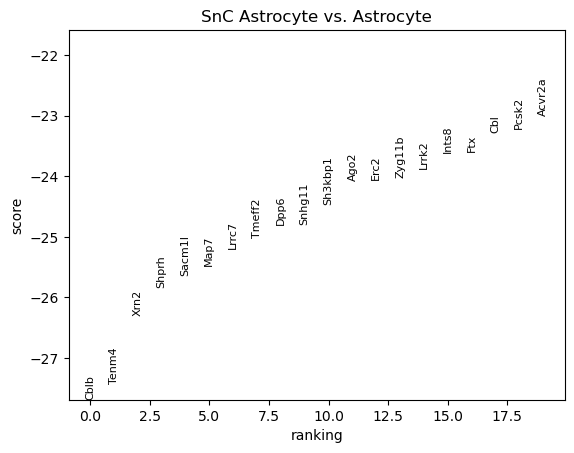

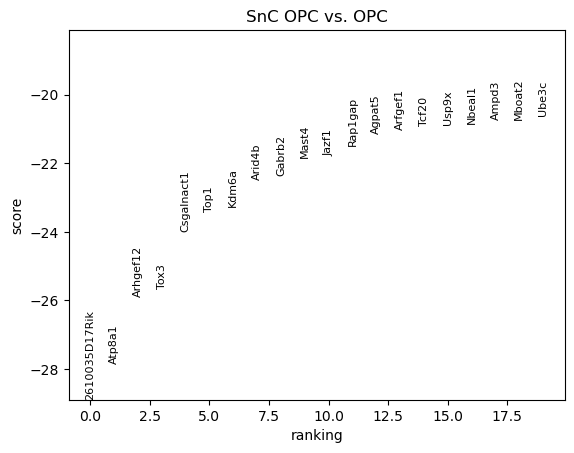

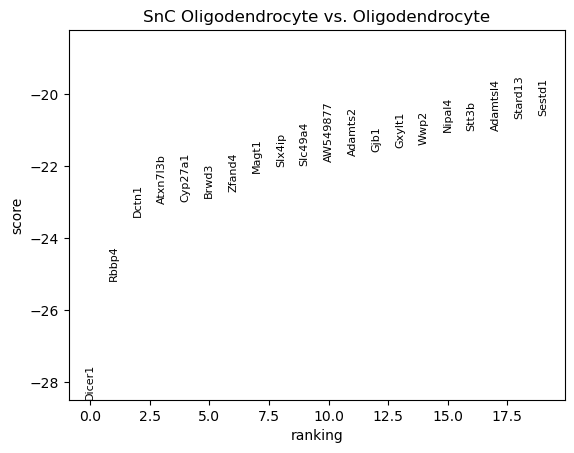

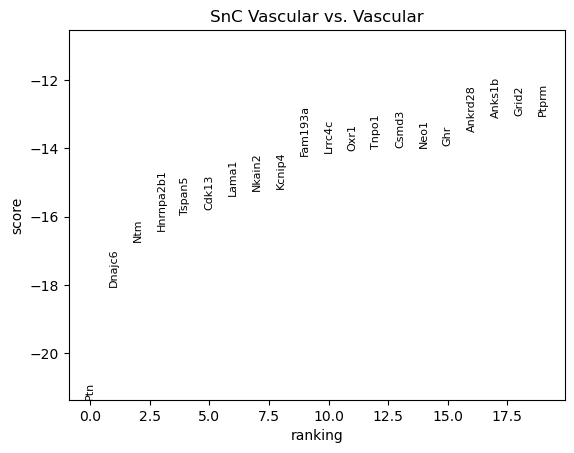

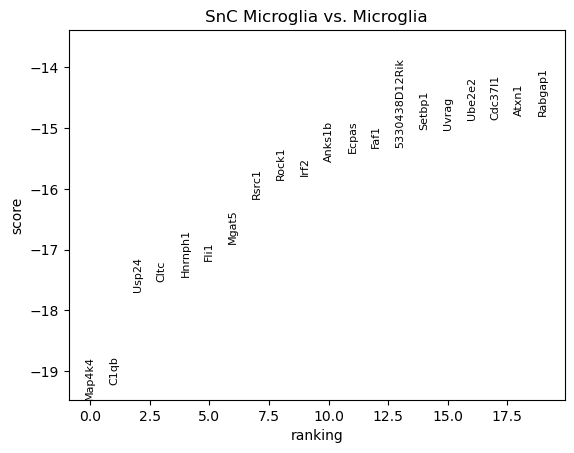

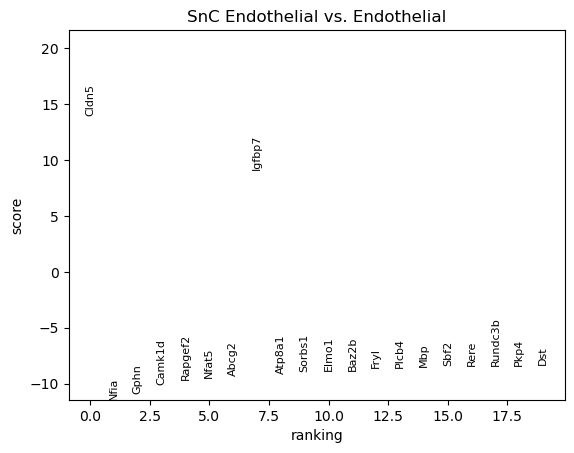

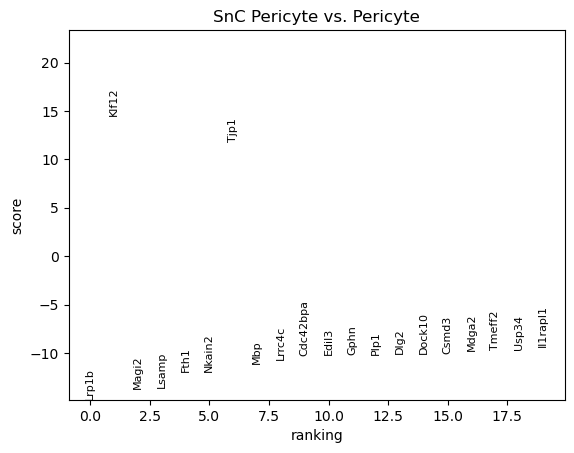

In [ ]:
p_threshold = 1e-10
lfc_threshold = 1
self.find_markers(col_celltype="Senescent_Cell_Label_by_Type")
df_snc_markers = {}
df_snc_markers["All"] = self.get_markers_df(
    n_genes=50, col_celltype="Senescent_Cell_Label_by_Type",
    log2fc_threshold=1, p_threshold=1e-10)
# print(df_snc_markers["All"].loc[pd.unique([
#     i[0] for i in df_snc_markers["All"].index.values if (
#         "SnC" in i[0])])].groupby("Senescent_Cell_Label_by_Type").apply(
#             lambda x: x.head(3)))
for x in self.rna.obs[col_celltype].unique():
    df_snc_markers[x] = self.find_markers(
        col_celltype="Senescent_Cell_Label_by_Type",
        reference=x, groups=[x, f"SnC {x}"], rankby_abs=True,
        inplace=False).reset_index(0, drop=True).assign(**{
            col_celltype: f"SnC {x}"}).reset_index().set_index([
                col_celltype, "names"])
df_snc_markers = pd.concat(df_snc_markers, names=["Comparison"])
df_snc_markers = df_snc_markers.rename_axis([
    "Comparison", col_celltype, "names"]).rename({
        "logfoldchanges": "log_fc"}, axis=1).assign(
            log_fc_abs=df_snc_markers["logfoldchanges"].abs())
df_snc_markers_top = df_snc_markers[df_snc_markers.pvals_adj < p_threshold]
df_snc_markers_top = df_snc_markers_top[
    df_snc_markers.log_fc_abs >= lfc_threshold]
df_snc_markers_top = df_snc_markers_top.groupby([
    "Comparison", col_celltype]).apply(
        lambda x: x.assign(scores_abs=x.scores.abs()).sort_values(
            "scores_abs", ascending=False).head(20),
        include_groups=False).reset_index([0, 1], drop=True)

## By Group

In [ ]:
res_rank_genes, p_threshold = {}, 1e-10
for x in self.rna.obs[col_batch].unique():
    res_rank_genes[x] = {}
    for c in self.rna.obs[self.rna.obs[col_batch] == x][
            col_celltype].unique():
        s_iter = (self.rna.obs[col_batch] == x) & (self.rna.obs[
            "Senescent_Cell_Label_by_Type"].isin([c, f"SnC {c}"]))
        if not all(self.rna[s_iter].obs[
                "Senescent_Cell_Label_by_Type"].value_counts() > 1):
            print(f"\n\nSkipping {c} because too few samples")
            continue
        tmp = sc.tl.rank_genes_groups(
            self.rna[s_iter], "Senescent_Cell_Label_by_Type", rankby_abs=True,
            layer="log1p", groups=[c, f"SnC {c}"], reference=c, copy=True)
        res_rank_genes[x][c] = sc.get.rank_genes_groups_df(
            tmp, f"SnC {c}", pval_cutoff=p_threshold)
    tmp = sc.tl.rank_genes_groups(
            self.rna[self.rna.obs[col_batch] == x],
            "Senescent_Cell_Label", rankby_abs=True,
            layer="log1p", reference="Non-Senescent", copy=True)
    res_rank_genes[x]["Overall"] = sc.get.rank_genes_groups_df(
            tmp, f"Senescent", pval_cutoff=p_threshold)
    res_rank_genes[x] = pd.concat(res_rank_genes[x], names=[col_celltype])
res_rank_genes = pd.concat(res_rank_genes, names=[col_batch])
res_rank_genes = res_rank_genes.assign(
    logfoldchanges_abs=res_rank_genes.logfoldchanges.abs())
res_rank_genes_top = res_rank_genes.reset_index().groupby([
    col_batch, col_celltype]).apply(
        lambda x: x.sort_values("logfoldchanges_abs").iloc[:20],
        include_groups=False).reset_index(2, drop=True).set_index(
            "names", append=True).rename_axis([
                col_batch, col_celltype, "variable"])
res_rank_genes_top



Skipping Endothelial because too few samples


Skipping Pericyte because too few samples


level_2     scores  logfoldchanges         pvals     pvals_adj  logfoldchanges_abs
Condition      annotation_predicted_labels variable                                                                                              
Ground Control Astrocyte                   Ptchd1                 3001  -6.886193      -24.943007  7.188098e-12  5.151630e-11           24.943007
                                           A230004M16Rik          3048  -6.829412      -24.948406  1.061847e-11  7.492829e-11           24.948406
                                           Gprin3                 3018  -6.862509      -25.013302  8.461548e-12  6.030149e-11           25.013302
                                           Rab27b                 2879  -7.030042      -25.015718  2.639612e-12  1.971919e-11           25.015718
                                           Dcx                    2801  -7.129227      -25.019531  1.308295e-12  1.004567e-11           25.019531
                                           Trpc5                  2822  -7.108056      -25.026670  1.520914e-12  1.159138e-11           25.026670
                                           Chga                   2958  -6.947851      -25.026773  4.689736e-12  3.409925e-11           25.026773
                                           Grm4                   3036  -6.841858      -25.042543  9.750568e-12  6.907589e-11           25.042543
                                           Cnnm1                  2564  -7.444217      -25.050856  1.325764e-13  1.112040e-12           25.050856
                                           Rnf165                 2687  -7.272196      -25.062073  4.681245e-13  3.746912e-12           25.062073
                                           P3h2                   3023  -6.854436      -25.070688  8.944256e-12  6.363614e-11           25.070688
                                           Cxadr                  2891  -7.016105      -25.074999  2.911086e-12  2.165699e-11           25.074999
                                           Tub                    2982  -6.908677      -25.079844  6.154062e-12  4.438641e-11           25.079844
                                           Ajap1                  2719  -7.231204      -25.080091  6.297604e-13  4.981359e-12           25.080091
                                           2900027M19Rik          2952  -6.956783      -25.084974  4.407089e-12  3.210922e-11           25.084974
                                           Rras2                  2758  -7.177088      -25.091570  9.293889e-13  7.247482e-12           25.091570
                                           C78859                 2729  -7.212387      -25.100170  7.212427e-13  5.684079e-12           25.100170
                                           Slitrk1                2927  -6.984007      -25.111959  3.644846e-12  2.678240e-11           25.111959
                                           Agap2                  3058  -6.819877      -25.113533  1.133412e-11  7.971678e-11           25.113533
                                           Gm49069                3064  -6.811824      -25.117409  1.197520e-11  8.406082e-11           25.117409
               Excitatory                  Chid1                  2194  -7.755886       -2.812142  7.950022e-13  6.598948e-12            2.812142
                                           Tatdn3                 2474  -7.369108       -3.169089  6.547531e-12  5.043685e-11            3.169089
                                           Septin1                2395  -7.469884       -3.197680  2.827833e-12  2.245877e-11            3.197680
                                           Dnah5                  2094  -7.936396       -3.283390  1.569717e-13  1.372307e-12            3.283390
                                           Gm38372                1989  -8.123888       -3.314180  4.984977e-14  4.589293e-13            3.314180
                                           Msrb2                  1693  -8.733174       -3.411550  1.162976e-15  1.221749

# Plot

## Comparison

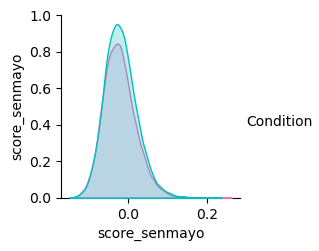

In [21]:
scores = self.rna.obs[[col_batch] + [
    f"score_{x}" for x in sen_metrics]].set_index(
        col_batch, append=True).reset_index()
sns.pairplot(scores, diag_kind="kde", diag_kws=dict(
    cut=0, fill=True, common_norm=True),
             hue=col_batch, palette=palette[col_batch])

## Scores

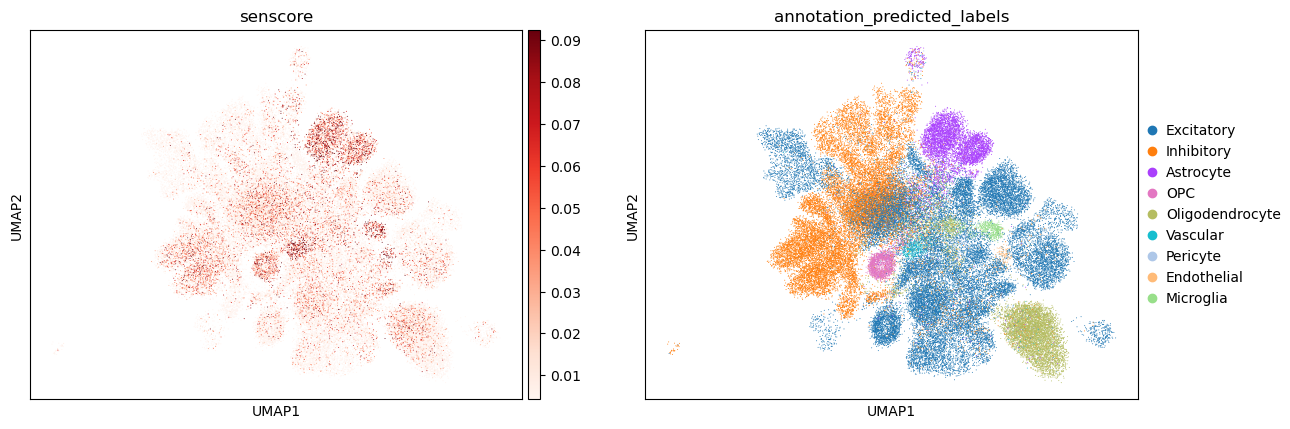

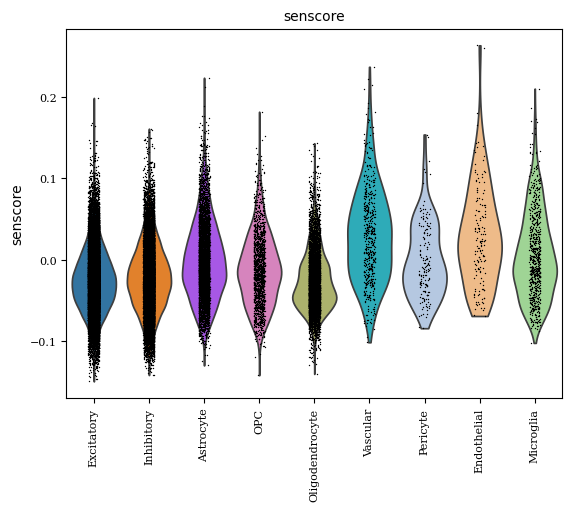

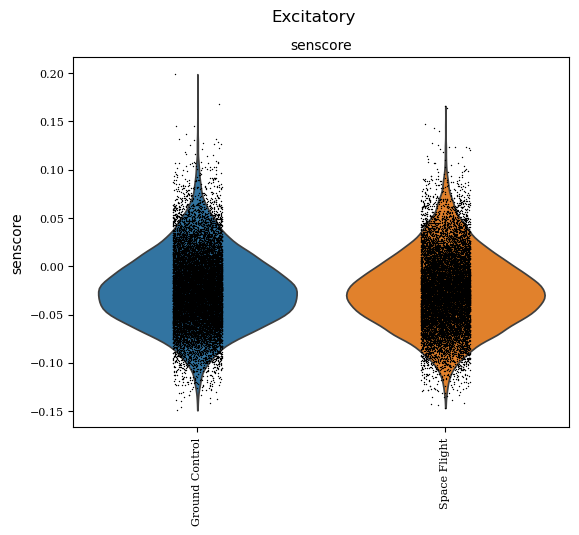

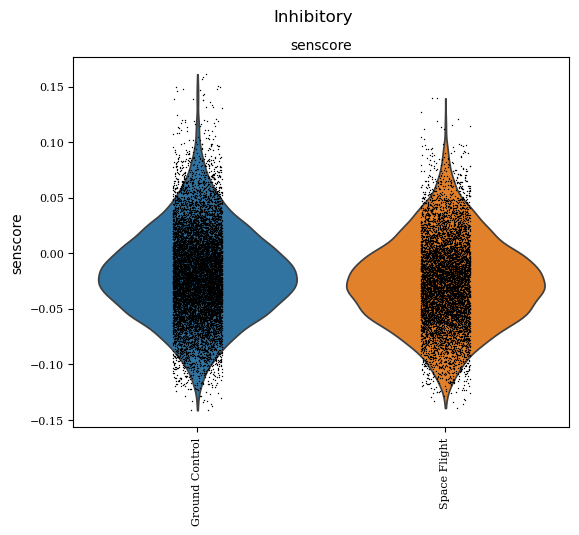

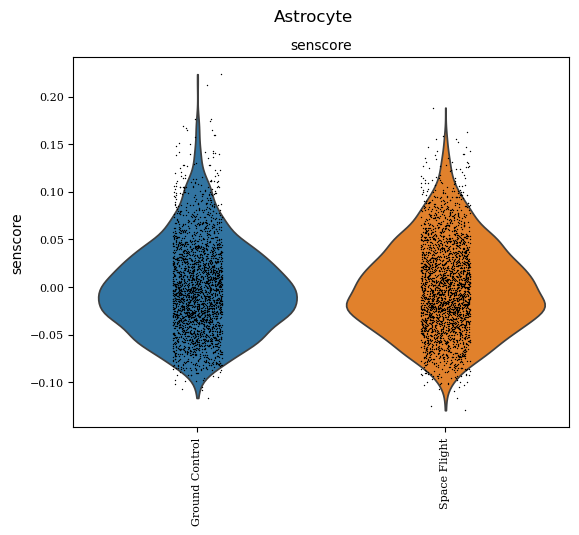

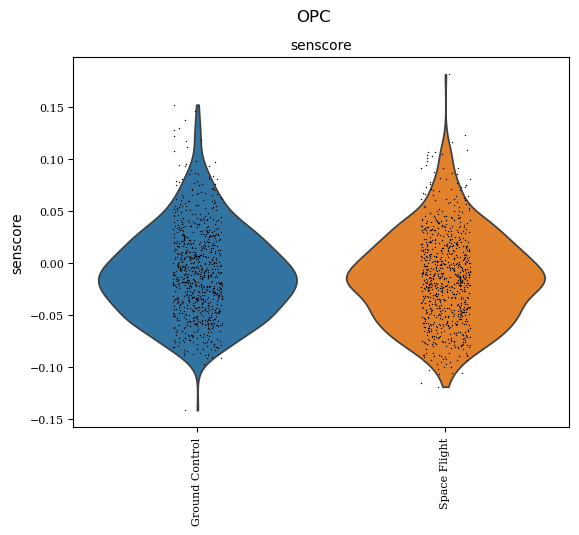

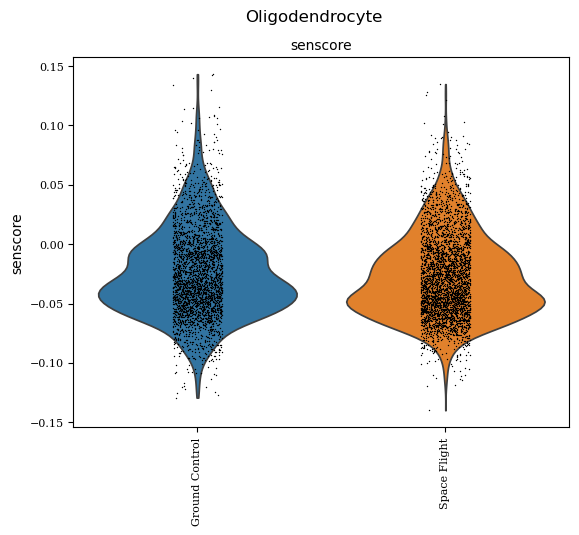

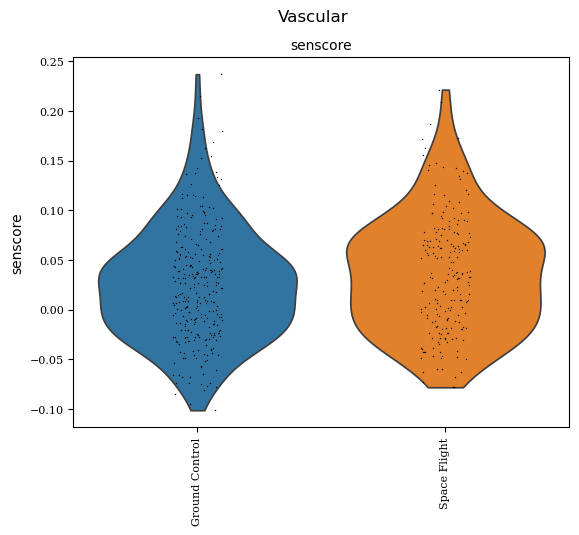

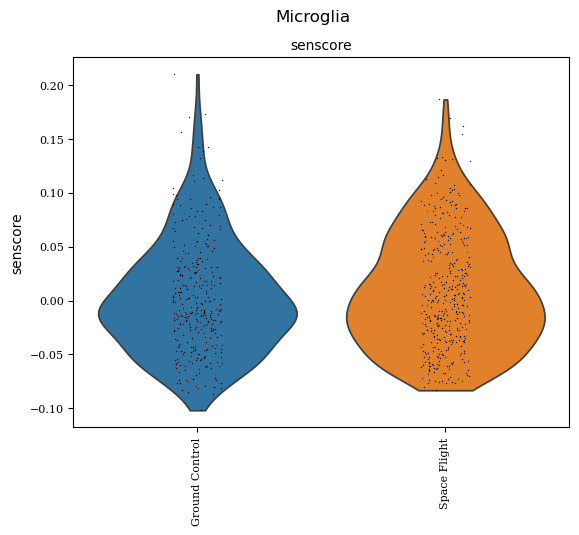

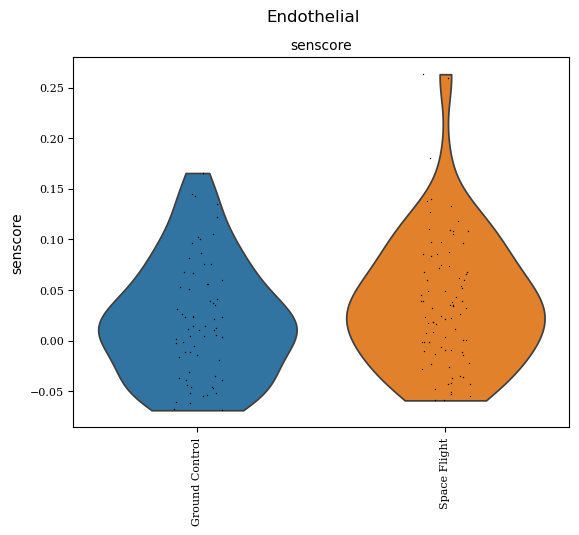

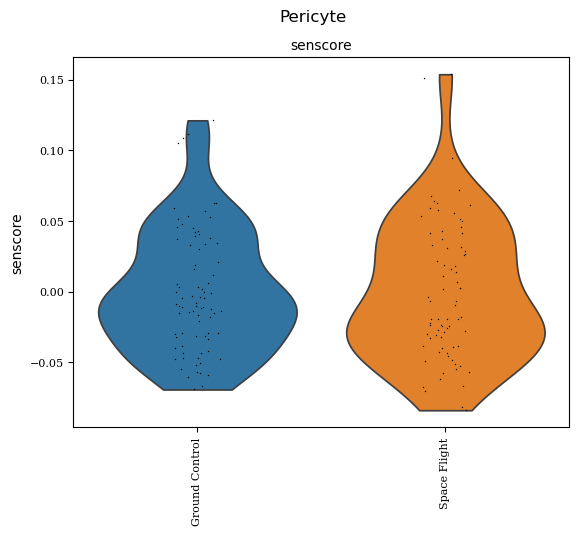

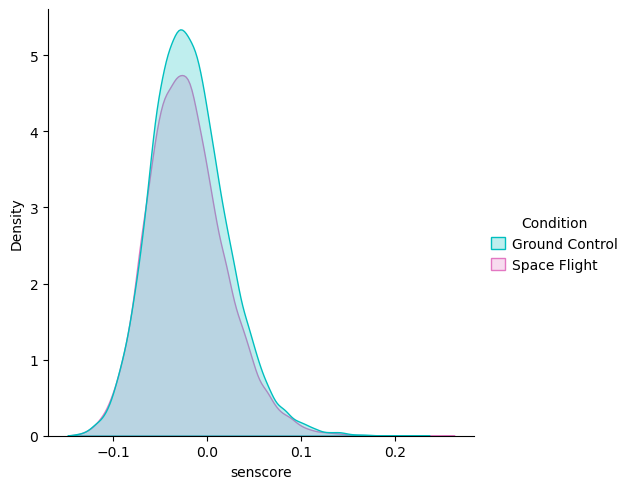

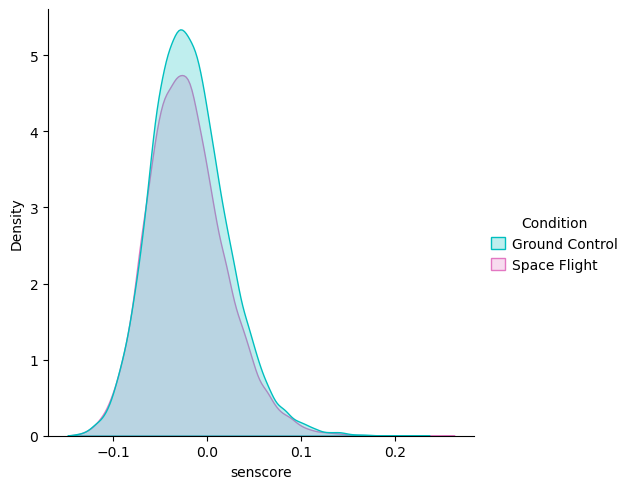

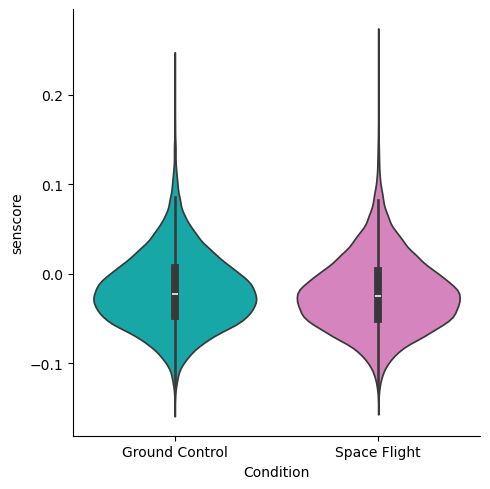

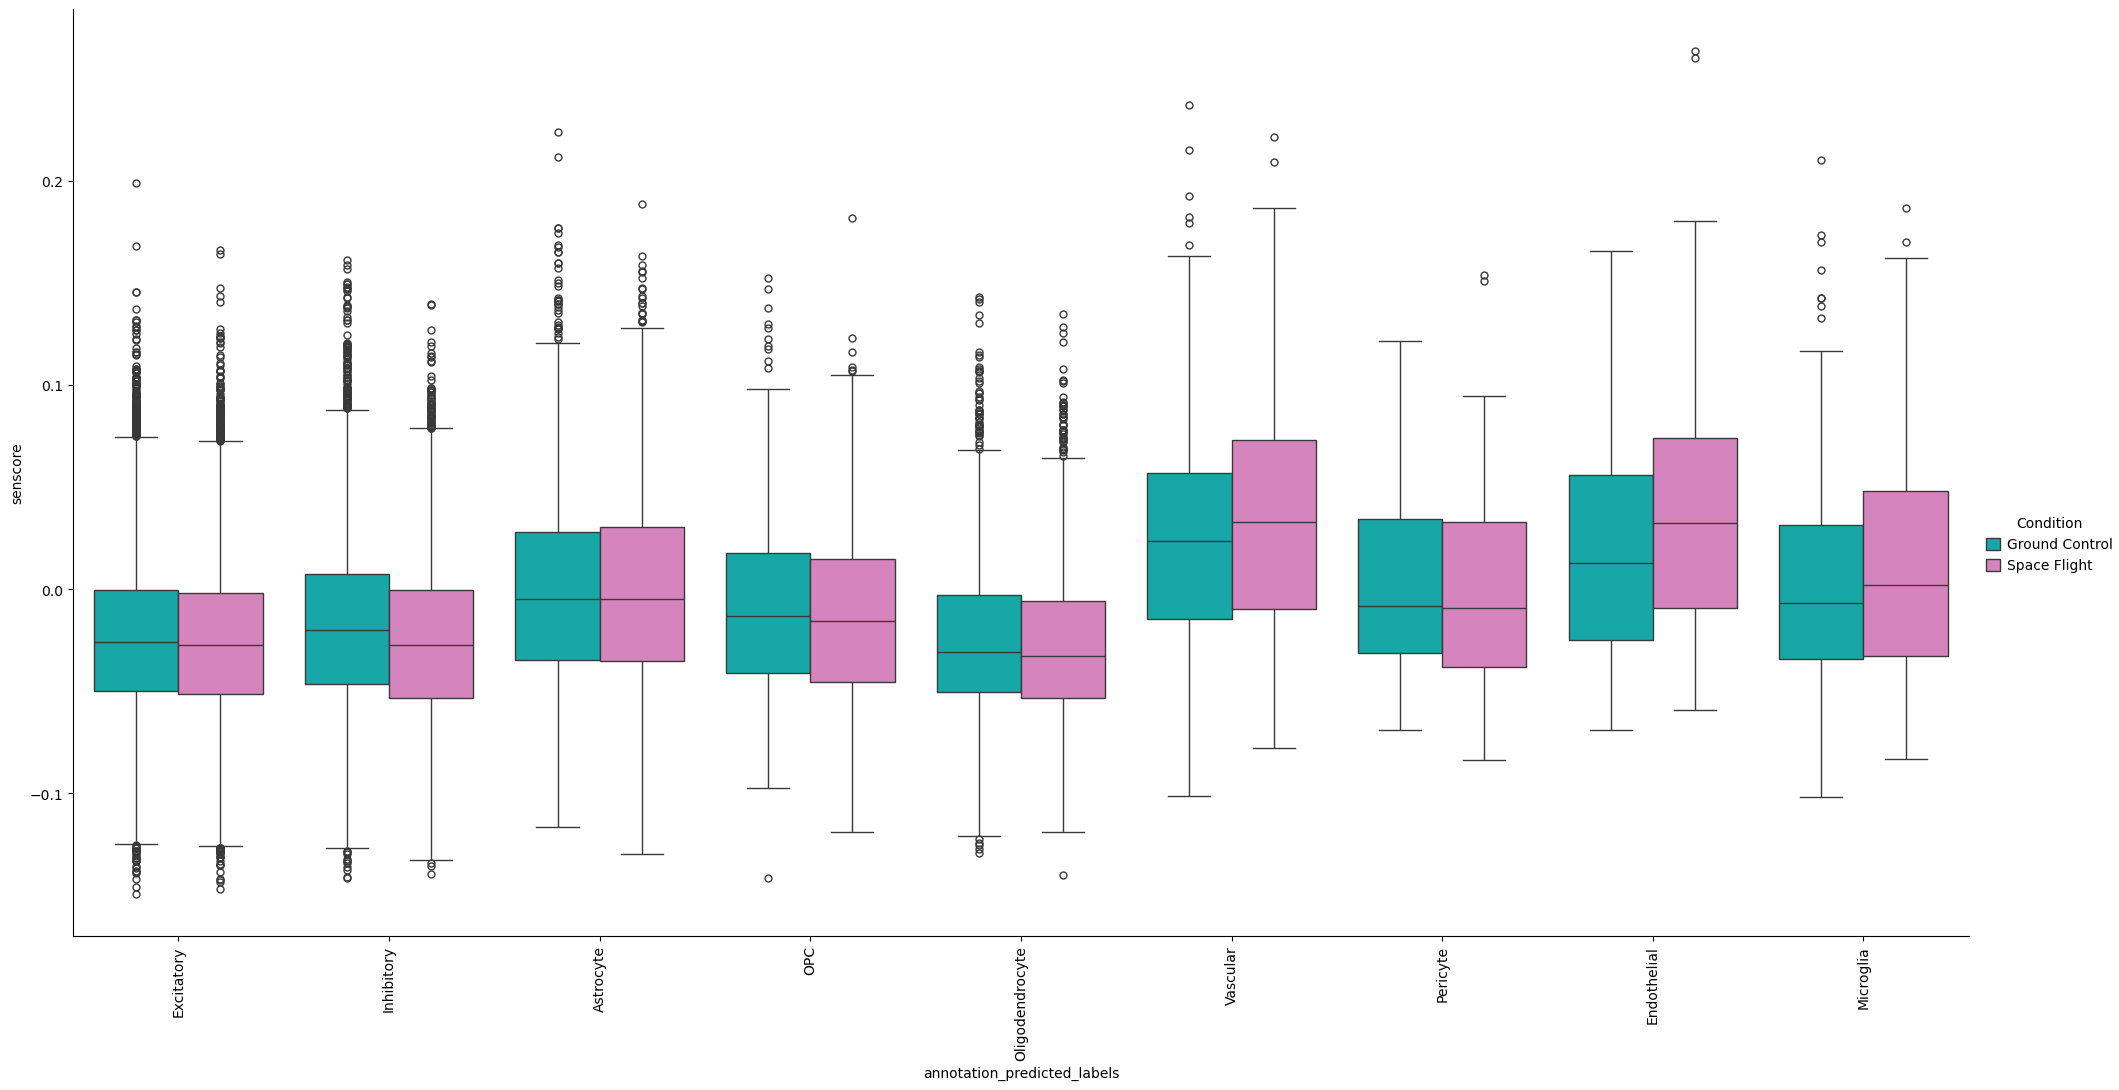

In [22]:
# UMAP with Senescence Scores
bnds = self.rna.obs["senscore"].describe(percentiles=[0.75, 0.99])
_ = self.plot(kind="umap", color=["senscore", col_celltype], umap=dict(
    palette=None, color_map="Reds", vmin=bnds["75%"], vmax=bnds["99%"]))

# Violin Plot of Senescence Scores
_ = self.plot(kind="violin", genes=["senscore"], common_norm=True,
              col_celltype=col_celltype, rotation=90)
_ = self.plot(kind="violin", genes=["senscore"], common_norm=True,
              by_group=col_celltype, col_wrap=1,
              col_celltype=col_batch, rotation=90)

# KDEs
fig_sen_kde = {}
for x in [col_condition, col_batch]:
    fig_sen_kde[x] = sns.displot(self.rna.obs, hue=x, x="senscore",
                                 palette=palette[x], kind="kde",
                                 cut=0, common_norm=True, fill=True)

# Overall (All Cell Types)
fig_sen_overall = sns.catplot(self.rna.obs, x=col_condition,
                              hue=col_condition, y="senscore",
                              palette=palette[col_condition], kind="violin")

# By Cell Type
fig_sen = sns.catplot(self.rna.obs, x=col_celltype, y="senscore",
                      palette=palette[col_batch],
                      hue=col_batch, kind="box", height=10, aspect=2)
for a in fig_sen.axes.flatten():
    a.tick_params(axis="x", labelrotation=90)

## Burden 

Group by sample and cell type and get percentage of senescent cells



                 min  25%  50%  75%   max
Condition                               
Ground Control  0.0  0.0  0.9  1.6  14.3
Space Flight    0.0  0.0  0.6  1.2   6.7


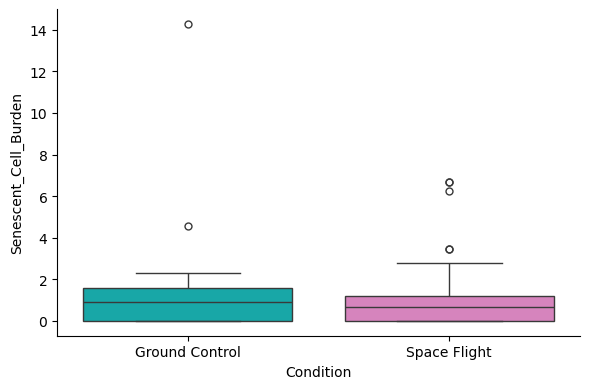

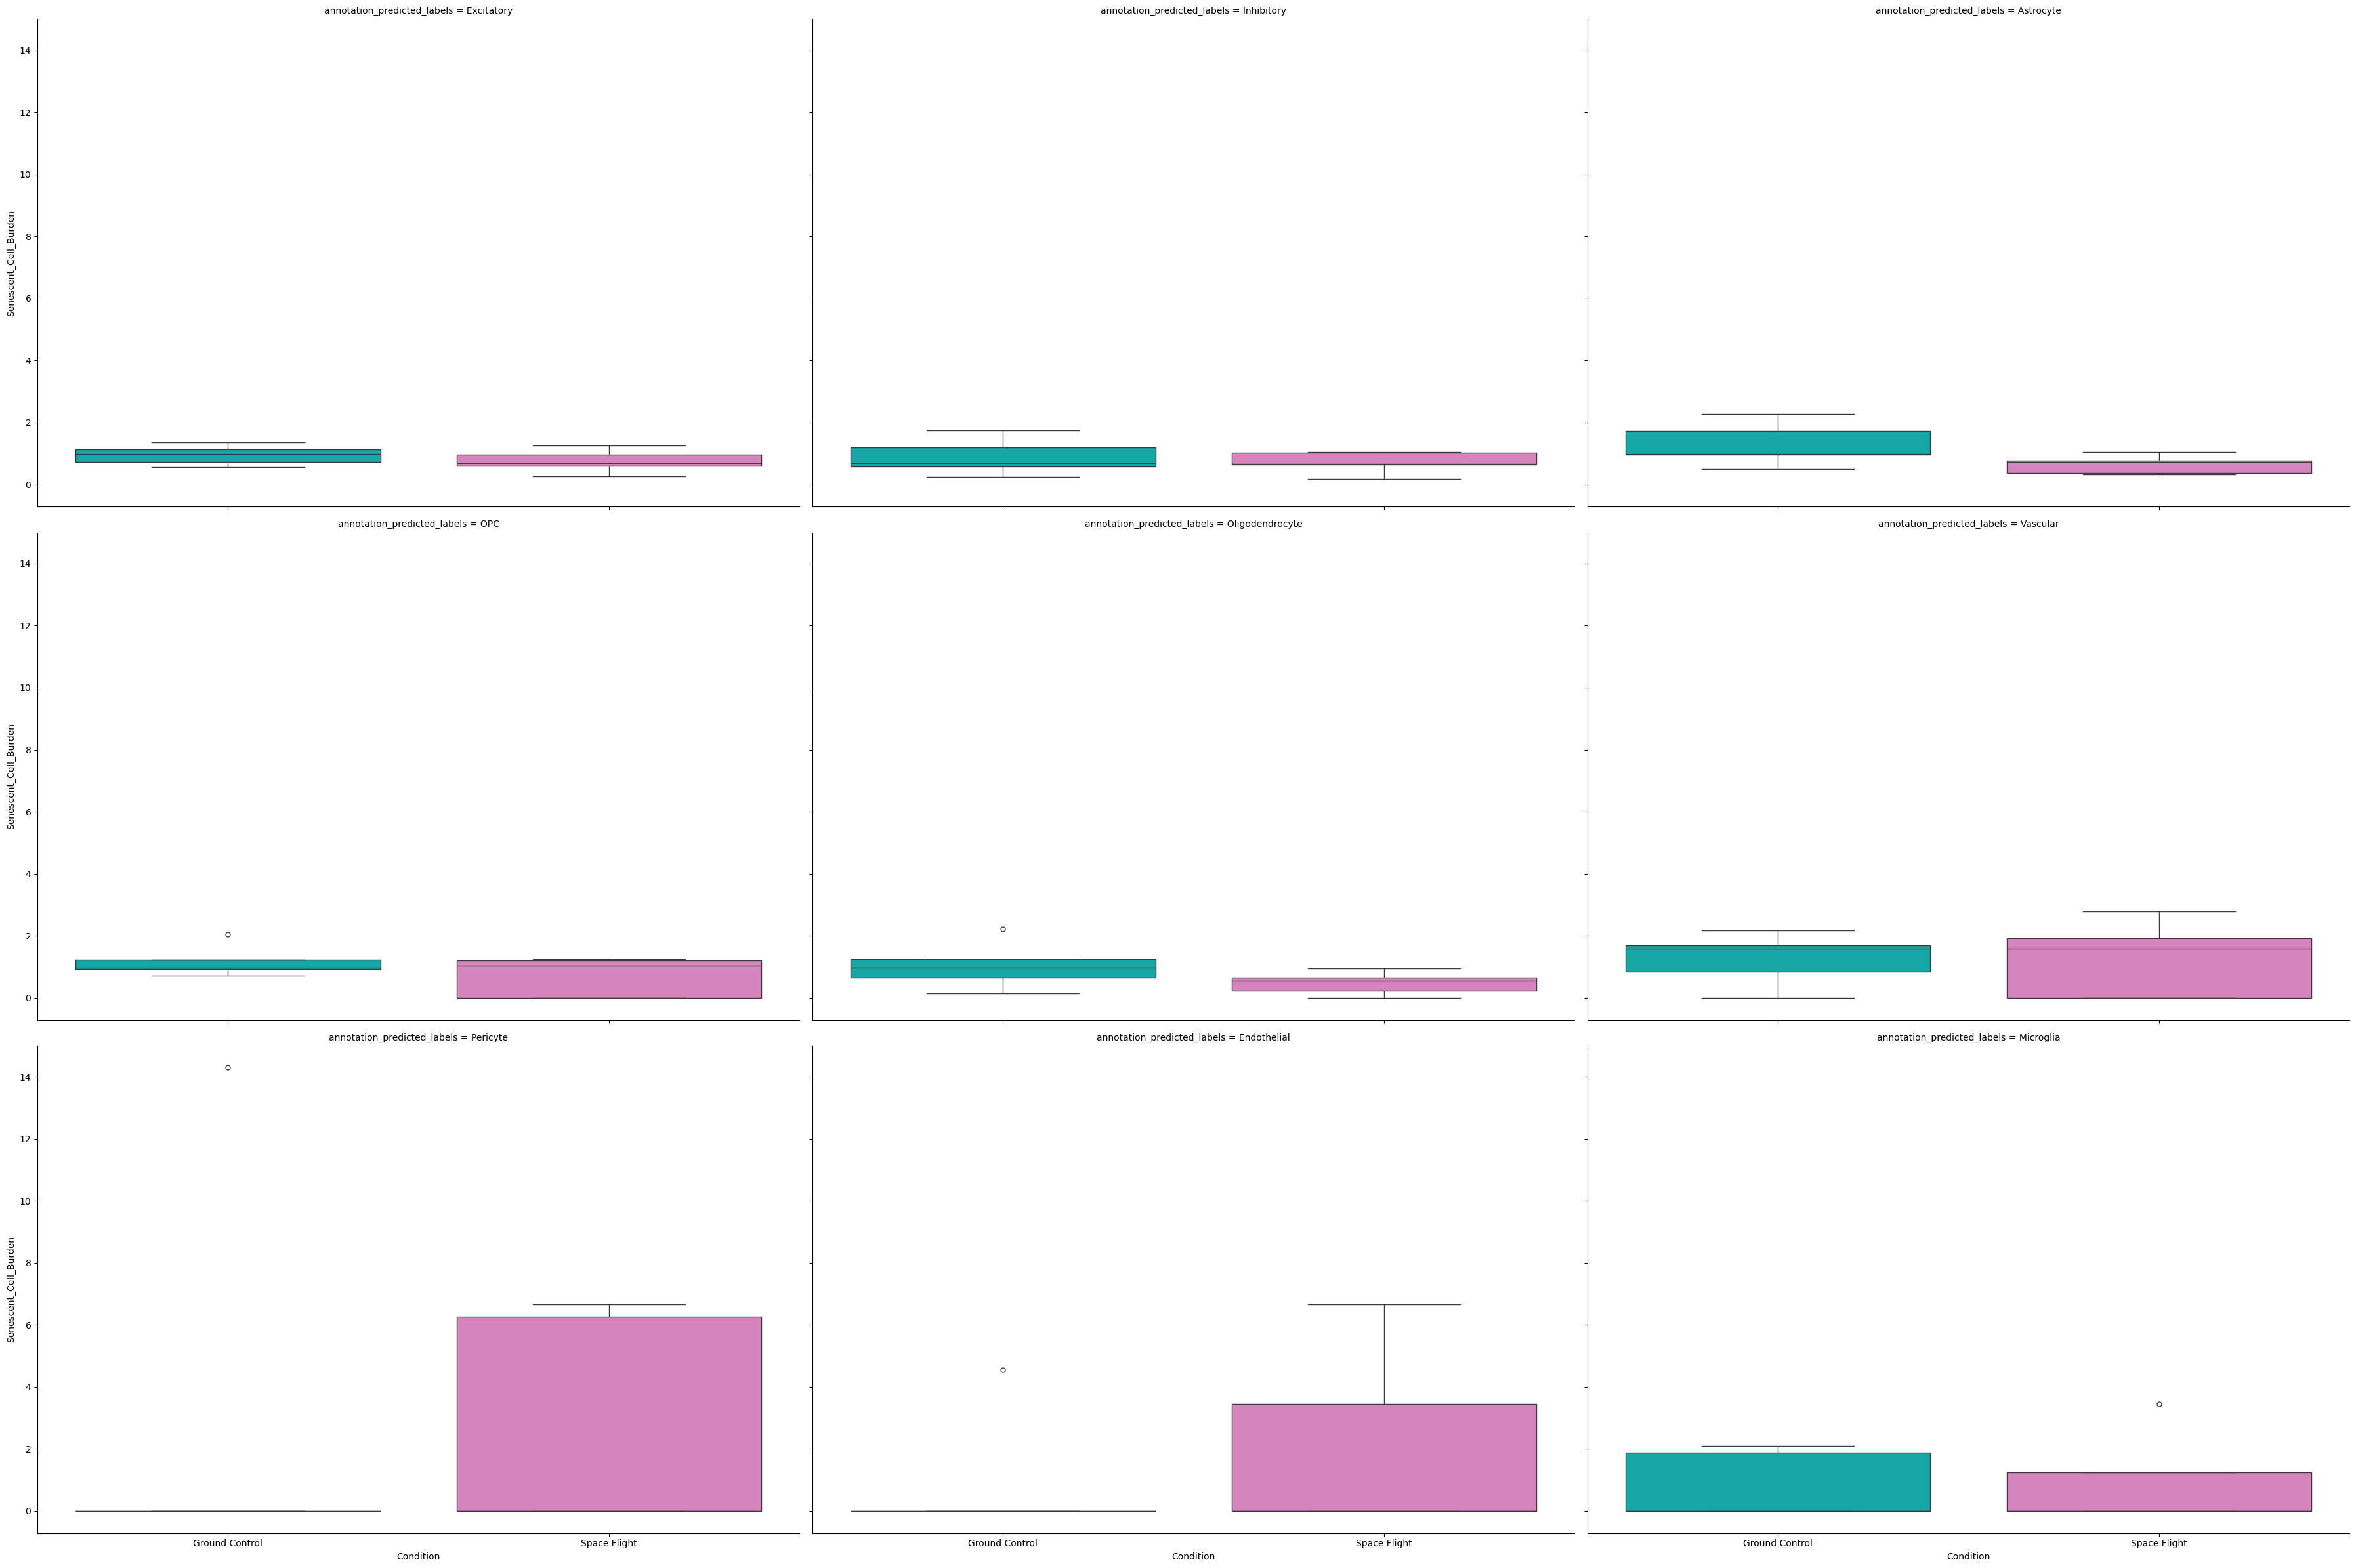

In [26]:
grps = [col_sample, col_celltype, col_batch]
dff = self.rna.obs[grps + ["Senescent_Cell"]].groupby(grps).apply(
    lambda x: x["Senescent_Cell"].mean(), include_groups=False
    ).to_frame("Senescent_Cell_Burden") * 100
# kws_plot = dict(kind="violin", split=False, , common_norm=True)
kws_plot = dict(kind="box", errorbar=("ci", 95))

sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            palette=palette[col_condition],
            hue=col_condition, data=dff, height=4, aspect=1.5)
sns.catplot(y="Senescent_Cell_Burden", x=col_condition, **kws_plot,
            col=col_celltype, palette=palette[col_condition], col_wrap=3,
            hue=col_condition, data=dff, height=8, aspect=1.5)
print("\n\n", round(dff["Senescent_Cell_Burden"].groupby(
    col_condition).describe()[["min", "25%", "50%", "75%", "max"]], 1))

# Analyze

## Regressions & ANOVAs & MEMs

In [ ]:
r_dff = polars.DataFrame(dff.reset_index())  # pymer-compatible aggregated df
r_rna = polars.DataFrame(self.rna.obs.rename({
    col_celltype: "CT_"}, axis=1).copy())  # pymer-compatible cell-level df
lvls = ["key_control", "key_treatment"]
factors = {col_condition: [keys[col_condition][i] for i in lvls]}

### Scores

##### Cell Type Random Effects

In [ ]:
# # Condition (Random Intercept Only)
# model_ri = lmer(
#     f"senscore ~ {col_condition} + (1 | {col_sample}) + (1 | CT_)",
#     data=r_rna)  # set up model
# model_ri.set_factors(factors)
# model_ri.set_transforms({"senscore": "zscore"})
# model_ri.anova(summary=True).show()

# # Condition (Condition as Random Effect)
# model_re = lmer(
#     f"senscore ~ {col_condition} + (1 | {col_sample})"
#     f" + (1 + {col_condition} | CT_)",
#     data=r_rna)  # set up model
# model_re.set_factors(factors)
# model_re.set_transforms({"senscore": "zscore"})
# model_re.anova(summary=True).show()

# # Results
# model_ri.summary().show()
# model_re.summary().show()
# compare(model_ri, model_re).show()

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Condition 
 1.000 
 inf 
 0.481 
 0.481 
 0.4878 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Condition 
 1.000 
 inf 
 0.910 
 0.910 
 0.3401 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Condition+(1|sample)+(1|CT_)) 
 
 
 Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -86331 
AIC: 172672 | BIC: 172717 
Residual error: 0.97 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.090 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.518 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.970 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.469 
 0.178 
 0.066 
 0.873 
 2.639 
 8.840 
 0.02738 
 * 
 
 
 
 ConditionSpace Flight 
 −0.040 
 0.058 
 −0.173 
 0.093 
 −0.694 
 8.128 
 0.5072 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Condition+(1|sample)+(1+Condition|CT_)) 
 
 
 Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -86310 
AIC: 172635 | BIC: 172699 
Residual error: 0.97 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.090 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.459 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 ConditionSpace Flight 
 0.130 
 
 
 
 
 
 
 
 
 
 CT_-cor 
 (Intercept) 
 0.968 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.970 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.416 
 0.159 
 0.056 
 0.775 
 2.617 
 8.989 
 0.02798 
 * 
 
 
 
 ConditionSpace Flight 
 0.069 
 0.073 
 −0.088 
 0.227 
 0.954 
 13.108 
 0.3573 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Analysis of Deviance Table 
 
 
 Model 1: lmer(senscore~Condition+(1|sample)+(1|CT_)) 
Model 2: lmer(senscore~Condition+(1|sample)+(1+Condition|CT_)) 
 
 
 
 AIC 
 BIC 
 logLik 
 npar 
 -2*log(L) 
 Chisq 
 Df 
 Pr(>Chisq) 
 
 
 
 
 
 1.00 
 172672.2 
 172717.4 
 −86331.1 
 5.00 
 172.66K 
 
 
 
 
 
 
 2.00 
 172635.8 
 172699.1 
 −86310.9 
 7.00 
 172.62K 
 40.33 
 2.00 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

#### Cell Type as Moderator

In [ ]:
# Condition + Cell Type
model_cac_mlm_i2 = lmer(
    f"senscore ~  Spaceflight + CT_ + (1 | {col_sample})", data=r_rna)
model_cac_mlm_i2.set_transforms({"senscore": "zscore"})
model_cac_mlm_i2.anova(summary=True).show()

# Condition * Cell Type
model_cac_mlm_i2b = lmer(
    f"senscore ~  Spaceflight * CT_ + (1 | {col_sample})", data=r_rna)
model_cac_mlm_i2b.set_transforms({"senscore": "zscore"})
model_cac_mlm_i2b.anova(summary=True).show()

# GLM Version of Results + Model Comparison
model_cac_mlm_i2.summary().show()
model_cac_mlm_i2b.summary().show()
compare(model_cac_mlm_i2, model_cac_mlm_i2b).show()

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 0.482 
 0.482 
 0.4876 
 
 
 
 CT_ 
 8.000 
 inf 
 399.175 
 3,193.400 
 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 62135' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 62135)' or larger];
but be warned that this may result in large computation time and memory use.



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 2.111 
 2.111 
 0.1463 
 
 
 
 CT_ 
 8.000 
 inf 
 397.366 
 3,178.928 
 
 *** 
 
 
 Spaceflight:CT_ 
 8.000 
 inf 
 6.654 
 53.232 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Spaceflight+CT_+(1|sample)) 
 
 
 Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -86323 
AIC: 172671 | BIC: 172780 
Residual error: 0.97 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.090 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.970 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 −0.074 
 0.041 
 −0.168 
 0.020 
 −1.811 
 8.267 
 0.1065 
 
 
 
 
 Spaceflight 
 −0.040 
 0.058 
 −0.173 
 0.093 
 −0.694 
 8.128 
 0.507 
 
 
 
 
 CT_Inhibitory 
 0.060 
 0.010 
 0.041 
 0.080 
 6.110 
 59,992.078 
 <.001 
 *** 
 
 
 
 CT_Astrocyte 
 0.579 
 0.015 
 0.550 
 0.608 
 39.392 
 62,120.810 
 
 *** 
 
 
 
 CT_OPC 
 0.316 
 0.025 
 0.267 
 0.364 
 12.709 
 62,124.572 
 <.001 
 *** 
 
 
 
 CT_Oligodendrocyte 
 −0.025 
 0.013 
 −0.051 
 0.001 
 −1.870 
 62,086.950 
 0.06148 
 . 
 
 
 
 CT_Vascular 
 1.303 
 0.043 
 1.218 
 1.388 
 30.132 
 62,123.659 
 <.001 
 *** 
 
 
 
 CT_Pericyte 
 0.589 
 0.077 
 0.438 
 0.741 
 7.635 
 62,120.058 
 <.001 
 *** 
 
 
 
 CT_Endothelial 
 1.345 
 0.079 
 1.190 
 1.499 
 17.030 
 62,120.011 
 <.001 
 *** 
 
 
 
 CT_Microglia 
 0.748 
 0.036 
 0.677 
 0.819 
 20.589 
 62,123.144 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: lmer(senscore~Spaceflight*CT_+(1|sample)) 
 
 
 Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -86312 
AIC: 172665 | BIC: 172846 
Residual error: 0.97 
 
 
 Random Effects: 
 
 Estimate 
 SE 
 CI-low 
 CI-high 
 T-stat 
 DF 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.090 
 
 
 
 
 
 
 
 
 
 Residual-sd 
 Observation 
 0.970 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 −0.066 
 0.041 
 −0.160 
 0.028 
 −1.604 
 8.423 
 0.1456 
 
 
 
 
 Spaceflight 
 −0.059 
 0.058 
 −0.191 
 0.074 
 −1.008 
 8.481 
 0.3413 
 
 
 
 
 CT_Inhibitory 
 0.065 
 0.014 
 0.039 
 0.092 
 4.799 
 58,056.282 
 <.001 
 *** 
 
 
 
 CT_Astrocyte 
 0.528 
 0.021 
 0.487 
 0.569 
 25.324 
 62,099.903 
 <.001 
 *** 
 
 
 
 CT_OPC 
 0.315 
 0.035 
 0.246 
 0.383 
 9.015 
 62,116.958 
 <.001 
 *** 
 
 
 
 CT_Oligodendrocyte 
 −0.047 
 0.019 
 −0.086 
 −0.009 
 −2.448 
 62,071.908 
 0.01438 
 * 
 
 
 
 CT_Vascular 
 1.168 
 0.056 
 1.058 
 1.278 
 20.759 
 62,113.988 
 <.001 
 *** 
 
 
 
 CT_Pericyte 
 0.548 
 0.107 
 0.337 
 0.758 
 5.097 
 62,111.541 
 <.001 
 *** 
 
 
 
 CT_Endothelial 
 1.038 
 0.119 
 0.805 
 1.270 
 8.736 
 62,111.060 
 <.001 
 *** 
 
 
 
 CT_Microglia 
 0.609 
 0.054 
 0.503 
 0.715 
 11.285 
 62,114.508 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_Inhibitory 
 −0.013 
 0.020 
 −0.052 
 0.026 
 −0.654 
 60,154.747 
 0.5131 
 
 
 
 
 Spaceflight:CT_Astrocyte 
 0.102 
 0.029 
 0.044 
 0.159 
 3.468 
 62,112.539 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_OPC 
 0.002 
 0.050 
 −0.095 
 0.100 
 0.045 
 62,116.576 
 0.9642 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.044 
 0.027 
 −0.008 
 0.096 
 1.662 
 62,079.779 
 0.09651 
 . 
 
 
 
 Spaceflight:CT_Vascular 
 0.329 
 0.088 
 0.157 
 0.501 
 3.741 
 62,116.370 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_Pericyte 
 0.087 
 0.154 
 −0.215 
 0.390 
 0.566 
 62,112.136 
 0.5716 
 
 
 
 
 Spaceflight:CT_Endothelial 
 0.552 
 0.159 
 0.241 
 0.864 
 3.473 
 62,111.781 
 <.001 
 *** 
 
 
 
 Spaceflight:CT_Microglia 
 0.256 
 0.073 
 0.113 
 0.399 
 3.503 
 62,115.031 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Analysis of Deviance Table 
 
 
 Model 1: lmer(senscore~Spaceflight+CT_+(1|sample)) 
Model 2: lmer(senscore~Spaceflight*CT_+(1|sample)) 
 
 
 
 AIC 
 BIC 
 logLik 
 npar 
 -2*log(L) 
 Chisq 
 Df 
 Pr(>Chisq) 
 
 
 
 
 
 1.00 
 172671.8 
 172780.2 
 −86323.9 
 12.00 
 172.60K 
 
 
 
 
 
 
 2.00 
 172665.8 
 172846.5 
 −86312.9 
 20.00 
 172.54K 
 53.24 
 8.00 
 <.001 
 *** 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

### Binary Snc/Not

Multilevel Logistic Regression

#### Cell Type Random Effects

In [28]:
glmmod = {}
for x in ["1", f"1 + Spaceflight"]:
    sep = "|" if x == "1" else "||"
    fff = str(f"Senescent_Cell ~ Spaceflight"
              f" + (1 | {col_sample}) + ({x} {sep} CT_)")
    glmmod[x] = glmer(fff, data=r_rna, family="binomial")
    # glmmod[x].set_factors(factors)
    glmmod[x].fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
    # print(glmmod[x].emmeans(col_condition))
    # print(glmmod[x].emmeans(col_age))
    glmmod[x].summary().show()
    # print(glmmod[x].ranef["CT_"])
compare(*[glmmod[x] for x in glmmod])

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')



Formula: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1|CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3092 
AIC: 6193 | BIC: 6229 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.331 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.000 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.010 
 0.007 
 0.013 
 0.002 
 −28.671 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.715 
 0.452 
 1.129 
 0.167 
 −1.439 
 inf 
 0.1502 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')

R messages: 
boundary (singular) fit: see help('isSingular')



Formula: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1+Spaceflight||CT_)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3092 
AIC: 6195 | BIC: 6240 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.331 
 
 
 
 
 
 
 
 
 
 CT_-sd 
 (Intercept) 
 0.000 
 
 
 
 
 
 
 
 
 
 CT_.1-sd 
 Spaceflight 
 0.019 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.010 
 0.007 
 0.013 
 0.002 
 −29.015 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.715 
 0.453 
 1.127 
 0.166 
 −1.446 
 inf 
 0.1483 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

GT(_tbl_data=shape: (2, 10)
┌─────────────┬─────────────┬──────────────┬──────┬───┬─────┬────────────┬───────┬─────┐
│ AIC         ┆ BIC         ┆ logLik       ┆ npar ┆ … ┆ Df  ┆ Pr(>Chisq) ┆ stars ┆ ids │
│ ---         ┆ ---         ┆ ---          ┆ ---  ┆   ┆ --- ┆ ---        ┆ ---   ┆ --- │
│ f64         ┆ f64         ┆ f64          ┆ i64  ┆   ┆ f64 ┆ str        ┆ str   ┆ i64 │
╞═════════════╪═════════════╪══════════════╪══════╪═══╪═════╪════════════╪═══════╪═════╡
│ 6193.410628 ┆ 6229.558887 ┆ -3092.705314 ┆ 4    ┆ … ┆ 0.0 ┆            ┆       ┆ 1   │
│ 6195.410132 ┆ 6240.595456 ┆ -3092.705066 ┆ 5    ┆ … ┆ 1.0 ┆ 0.982      ┆       ┆ 2   │
└─────────────┴─────────────┴──────────────┴──────┴───┴─────┴────────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x78a73495d310>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x78a72c576690>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1|CT_))   \nModel 2: glmer(Senescent_Cell~Spaceflight+(1|sample)+(1+Spaceflight||CT_))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x78a727be67b0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x78a729ba18d0>, <great_tables._gt_data.FormatInfo object at 0x78a729adbe50>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x78a729a45710>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='valu

#### Cell Type as Moderator

In [29]:
# Main Effects
fff = str(f"Senescent_Cell ~  Spaceflight + CT_ + (1 | {col_sample})")
glmmod_ct2b = glmer(fff, data=r_rna, family="binomial")
glmmod_ct2b.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
glmmod_ct2b.anova(summary=True).show()
glmmod_ct2b.summary().show()

# Interaction
fff = str(f"Senescent_Cell ~  Spaceflight * CT_ + (1 | {col_sample})")
model_allix = glmer(fff, data=r_rna, family="binomial")
model_allix.fit(exponentiate=True, ncpus=ncpus)  # estimates => odds
model_allix.anova(summary=True).show()
model_allix.summary().show()
res_allix_fixed = pd.DataFrame(model_allix.result_fit[[
    "term", "estimate", "p_value"]], columns=[
        "Term", "OR", "P"]).set_index("Term")
res_allix_fixed.loc[:, "Log-Odds"] = np.log(
    res_allix_fixed.OR.astype(float))
res_allix_fixed.loc[:, "Significance"] = res_allix_fixed.P.apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if (
        x < 0.05) else "")
print(res_allix_fixed)

# Model Comparison
compare(glmmod_ct2b, model_allix)

ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 2.142 
 2.142 
 0.1433 
 
 
 
 CT_ 
 8.000 
 inf 
 1.458 
 11.664 
 0.1669 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Spaceflight+CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3087 
AIC: 6197 | BIC: 6297 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.324 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.010 
 0.007 
 0.014 
 0.002 
 −27.847 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.713 
 0.453 
 1.122 
 0.165 
 −1.463 
 inf 
 0.1433 
 
 
 
 
 CT_Inhibitory 
 0.856 
 0.689 
 1.064 
 0.095 
 −1.401 
 inf 
 0.1612 
 
 
 
 
 CT_Astrocyte 
 0.976 
 0.712 
 1.338 
 0.157 
 −0.148 
 inf 
 0.8824 
 
 
 
 
 CT_OPC 
 0.821 
 0.458 
 1.470 
 0.244 
 −0.664 
 inf 
 0.5069 
 
 
 
 
 CT_Oligodendrocyte 
 0.867 
 0.642 
 1.171 
 0.133 
 −0.931 
 inf 
 0.3518 
 
 
 
 
 CT_Vascular 
 1.411 
 0.668 
 2.978 
 0.538 
 0.903 
 inf 
 0.3666 
 
 
 
 
 CT_Pericyte 
 2.056 
 0.679 
 6.231 
 1.163 
 1.275 
 inf 
 0.2024 
 
 
 
 
 CT_Endothelial 
 3.121 
 1.165 
 8.360 
 1.569 
 2.263 
 inf 
 0.02361 
 * 
 
 
 
 CT_Microglia 
 1.232 
 0.613 
 2.475 
 0.439 
 0.585 
 inf 
 0.5584 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

R messages: 
Convergence status
: [1] FALSE
attr(,"gradient")
[1] 0.001052006

R messages: 
Convergence status
: [1] FALSE
attr(,"gradient")
[1] 0.001052006



ANOVA (Type III tests) 
 
 
 model term 
 df1 
 df2 
 F_ratio 
 Chisq 
 p_value 
 
 
 
 
 
 Spaceflight 
 1.000 
 inf 
 0.061 
 0.061 
 0.8055 
 
 
 
 CT_ 
 8.000 
 inf 
 1.255 
 10.040 
 0.2624 
 
 
 
 Spaceflight:CT_ 
 8.000 
 inf 
 0.616 
 4.928 
 0.765 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

Formula: glmer(Senescent_Cell~Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -3085 
AIC: 6209 | BIC: 6380 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.318 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.010 
 0.007 
 0.014 
 0.002 
 −27.762 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.745 
 0.463 
 1.199 
 0.181 
 −1.212 
 inf 
 0.2255 
 
 
 
 
 CT_Inhibitory 
 0.906 
 0.691 
 1.189 
 0.126 
 −0.710 
 inf 
 0.4779 
 
 
 
 
 CT_Astrocyte 
 0.967 
 0.637 
 1.470 
 0.206 
 −0.156 
 inf 
 0.8758 
 
 
 
 
 CT_OPC 
 1.046 
 0.538 
 2.033 
 0.355 
 0.132 
 inf 
 0.8952 
 
 
 
 
 CT_Oligodendrocyte 
 0.953 
 0.644 
 1.409 
 0.190 
 −0.241 
 inf 
 0.8096 
 
 
 
 
 CT_Vascular 
 1.202 
 0.455 
 3.174 
 0.596 
 0.371 
 inf 
 0.7103 
 
 
 
 
 CT_Pericyte 
 1.130 
 0.182 
 7.013 
 1.053 
 0.131 
 inf 
 0.8955 
 
 
 
 
 CT_Endothelial 
 1.445 
 0.174 
 11.999 
 1.561 
 0.341 
 inf 
 0.733 
 
 
 
 
 CT_Microglia 
 1.114 
 0.424 
 2.928 
 0.549 
 0.219 
 inf 
 0.8269 
 
 
 
 
 Spaceflight:CT_Inhibitory 
 0.852 
 0.538 
 1.349 
 0.200 
 −0.683 
 inf 
 0.4945 
 
 
 
 
 Spaceflight:CT_Astrocyte 
 1.028 
 0.548 
 1.928 
 0.330 
 0.085 
 inf 
 0.9323 
 
 
 
 
 Spaceflight:CT_OPC 
 0.481 
 0.134 
 1.721 
 0.313 
 −1.126 
 inf 
 0.2602 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.805 
 0.439 
 1.477 
 0.249 
 −0.701 
 inf 
 0.4833 
 
 
 
 
 Spaceflight:CT_Vascular 
 1.559 
 0.363 
 6.702 
 1.160 
 0.597 
 inf 
 0.5504 
 
 
 
 
 Spaceflight:CT_Pericyte 
 3.101 
 0.360 
 26.672 
 3.405 
 1.031 
 inf 
 0.3027 
 
 
 
 
 Spaceflight:CT_Endothelial 
 3.492 
 0.312 
 39.100 
 4.304 
 1.014 
 inf 
 0.3103 
 
 
 
 
 Spaceflight:CT_Microglia 
 1.238 
 0.320 
 4.792 
 0.855 
 0.309 
 inf 
 0.7569 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

                                      OR         P  Log-Odds Significance
Term                                                                     
(Intercept)                     0.009792       0.0 -4.626240          ***
Spaceflight                     0.745295  0.225493 -0.293975             
CT_Inhibitory                   0.906357  0.477903 -0.098322             
CT_Astrocyte                    0.967189  0.875793 -0.033362             
CT_OPC                          1.045722  0.895168  0.044707             
CT_Oligodendrocyte              0.953039  0.809604 -0.048099             
CT_Vascular                     1.202039  0.710317  0.184020             
CT_Pericyte                     1.130137  0.895496  0.122339             
CT_Endothelial                  1.445355  0.733018  0.368355             
CT_Microglia                     1.11387  0.826872  0.107841             
Spaceflight:CT_Inhibitory       0.852029  0.494523 -0.160135             
Spaceflight:CT_Astrocyte        1.0276

GT(_tbl_data=shape: (2, 10)
┌─────────────┬─────────────┬──────────────┬──────┬───┬─────┬────────────┬───────┬─────┐
│ AIC         ┆ BIC         ┆ logLik       ┆ npar ┆ … ┆ Df  ┆ Pr(>Chisq) ┆ stars ┆ ids │
│ ---         ┆ ---         ┆ ---          ┆ ---  ┆   ┆ --- ┆ ---        ┆ ---   ┆ --- │
│ f64         ┆ f64         ┆ f64          ┆ i64  ┆   ┆ f64 ┆ str        ┆ str   ┆ i64 │
╞═════════════╪═════════════╪══════════════╪══════╪═══╪═════╪════════════╪═══════╪═════╡
│ 6197.995871 ┆ 6297.403583 ┆ -3087.997935 ┆ 11   ┆ … ┆ 0.0 ┆            ┆       ┆ 1   │
│ 6209.013721 ┆ 6380.717951 ┆ -3085.50686  ┆ 19   ┆ … ┆ 8.0 ┆ 0.759      ┆       ┆ 2   │
└─────────────┴─────────────┴──────────────┴──────┴───┴─────┴────────────┴───────┴─────┘, _body=<great_tables._gt_data.Body object at 0x78a7348b91d0>, _boxhead=Boxhead([ColInfo(var='ids', type=<ColInfoTypeEnum.stub: 2>, column_label='', column_align='right', column_width=None), ColInfo(var='AIC', type=<ColInfoTypeEnum.default: 1>, column_label='AIC', column_align='right', column_width=None), ColInfo(var='BIC', type=<ColInfoTypeEnum.default: 1>, column_label='BIC', column_align='right', column_width=None), ColInfo(var='logLik', type=<ColInfoTypeEnum.default: 1>, column_label='logLik', column_align='right', column_width=None), ColInfo(var='npar', type=<ColInfoTypeEnum.default: 1>, column_label='npar', column_align='right', column_width=None), ColInfo(var='-2*log(L)', type=<ColInfoTypeEnum.default: 1>, column_label='-2*log(L)', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='Df', type=<ColInfoTypeEnum.default: 1>, column_label='Df', column_align='right', column_width=None), ColInfo(var='Pr(>Chisq)', type=<ColInfoTypeEnum.default: 1>, column_label='Pr(>Chisq)', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x78a72928b890>, _spanners=Spanners([]), _heading=Heading(title='Analysis of Deviance Table', subtitle=Md(text='Model 1: glmer(Senescent_Cell~Spaceflight+CT_+(1|sample))   \nModel 2: glmer(Senescent_Cell~Spaceflight*CT_+(1|sample))   \n'), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x78a727df3540>, _formats=[<great_tables._gt_data.FormatInfo object at 0x78a729b364b0>, <great_tables._gt_data.FormatInfo object at 0x78a729b35af0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x78a729b365d0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'),

### Lower SnC Threshold

In [30]:
# Column for Lower Threshold Classification
chp = f"Senescent_Cell_{use_metric}_{p_h}"  # column name

# Cell Type Random Effects
# fff = str(f"{chp} ~ Spaceflight"
#           f" + (1 | {col_sample}) + (1 + Spaceflight || CT_)")
# glmmod_lenient_thresh = glmer(fff, data=r_rna, family="binomial")
# glmmod_lenient_thresh.fit(exponentiate=True, ncpus=ncpus)  # => odds
# glmmod_lenient_thresh.summary().show()

# Cell Type as Moderator
fff = str(f"{chp} ~ Spaceflight * CT_ + (1 | {col_sample})")
glmmod_lenient_thresh_ct = glmer(fff, data=r_rna, family="binomial")
glmmod_lenient_thresh_ct.fit(exponentiate=True, ncpus=ncpus)  # => odds
glmmod_lenient_thresh_ct.summary().show()

Formula: glmer(Senescent_Cell_senmayo_3~Spaceflight*CT_+(1|sample)) 
 
 
 Family: binomial (link: default ) 
Number of observations: 62135 
Confidence intervals: parametric 
--------------------- 
Log-likelihood: -7710 
AIC: 15459 | BIC: 15631 
Residual error: 1.0 
 
 
 Random Effects: 
 
 Estimate 
 CI-low 
 CI-high 
 SE 
 Z-stat 
 df 
 p 
 
 
 
 
 
 sample-sd 
 (Intercept) 
 0.238 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Fixed Effects: 
 
 
 
 
 
 
 
 
 
 
 
 
 (Intercept) 
 0.030 
 0.024 
 0.038 
 0.004 
 −29.809 
 inf 
 <.001 
 *** 
 
 
 
 Spaceflight 
 0.851 
 0.612 
 1.185 
 0.144 
 −0.956 
 inf 
 0.3392 
 
 
 
 
 CT_Inhibitory 
 0.954 
 0.813 
 1.119 
 0.078 
 −0.581 
 inf 
 0.561 
 
 
 
 
 CT_Astrocyte 
 0.990 
 0.775 
 1.265 
 0.124 
 −0.078 
 inf 
 0.9379 
 
 
 
 
 CT_OPC 
 0.998 
 0.662 
 1.503 
 0.209 
 −0.010 
 inf 
 0.9923 
 
 
 
 
 CT_Oligodendrocyte 
 0.982 
 0.781 
 1.234 
 0.114 
 −0.158 
 inf 
 0.8742 
 
 
 
 
 CT_Vascular 
 1.052 
 0.564 
 1.963 
 0.335 
 0.161 
 inf 
 0.8725 
 
 
 
 
 CT_Pericyte 
 1.186 
 0.414 
 3.399 
 0.637 
 0.317 
 inf 
 0.7514 
 
 
 
 
 CT_Endothelial 
 0.983 
 0.220 
 4.400 
 0.752 
 −0.023 
 inf 
 0.982 
 
 
 
 
 CT_Microglia 
 0.969 
 0.531 
 1.767 
 0.297 
 −0.103 
 inf 
 0.9182 
 
 
 
 
 Spaceflight:CT_Inhibitory 
 0.794 
 0.612 
 1.030 
 0.105 
 −1.738 
 inf 
 0.08215 
 . 
 
 
 
 Spaceflight:CT_Astrocyte 
 0.883 
 0.610 
 1.279 
 0.167 
 −0.658 
 inf 
 0.5104 
 
 
 
 
 Spaceflight:CT_OPC 
 1.052 
 0.575 
 1.927 
 0.325 
 0.165 
 inf 
 0.8688 
 
 
 
 
 Spaceflight:CT_Oligodendrocyte 
 0.898 
 0.643 
 1.255 
 0.153 
 −0.630 
 inf 
 0.5289 
 
 
 
 
 Spaceflight:CT_Vascular 
 1.952 
 0.809 
 4.713 
 0.878 
 1.487 
 inf 
 0.1369 
 
 
 
 
 Spaceflight:CT_Pericyte 
 0.855 
 0.150 
 4.873 
 0.759 
 −0.177 
 inf 
 0.8597 
 
 
 
 
 Spaceflight:CT_Endothelial 
 1.531 
 0.217 
 10.802 
 1.526 
 0.427 
 inf 
 0.6692 
 
 
 
 
 Spaceflight:CT_Microglia 
 1.478 
 0.675 
 3.236 
 0.591 
 0.977 
 inf 
 0.3287 
 
 
 
 
 
 
 Signif. codes: 0 *** 0.001 ** 0.01 * 0.05 . 0.1

## Composition Analysis

### Cell Type

In [ ]:
# print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
# out_ctc = scflow.ax.analyze_composition(
#     self.rna, col_celltype, col_batch, col_sample=col_sample,
#     palette=palette[col_batch],
#     formula=None, key_modality="coda", reference_cell_type="automatic",
#     absence_threshold=0.1, est_fdr=0.1, level_order=[keys[
#         col_batch]["key_control"]] + keys[col_batch]["key_treatment"])
# plt.show()

# print(f"\n\n{'=' * 80}\nAged Subset\n{'=' * 80}\n\n")
# out_ctc_sf = scflow.ax.analyze_composition(
#     self.rna[self.rna.obs[col_age] != keys[col_age]["key_control"]],
#     col_celltype, col_condition, col_sample=col_sample,
#     formula=None, key_modality="coda", reference_cell_type="automatic",
#     absence_threshold=0.1, est_fdr=0.1, level_order=[keys[col_condition][
#         "key_control"]] + [keys[col_condition]["key_treatment"]])

### Senescent Cells

#### Tree-Aggregated

In [ ]:
# Setup
# col_celltype_hierarchy = [
#     f"{col_celltype}_hierarchical", "SnC_hierarchy"]
# col_celltype_hierarchy = [
#     "Senescent_Cell", f"{col_celltype}_hierarchical", "SnC_hierarchy",
#     "Senescent_Cell_Label_by_Type"]
# col_celltype_hierarchy = [
#     "Senescent_Cell_Label", f"SnC_hierarchy",
#     "Senescent_Cell_Label_by_Type"]
col_celltype_hierarchy = [
    "Senescent_Cell_Label", "Senescent_Cell_Label_by_Type"]
ref_celltype = self.rna.obs[col_celltype_hierarchy[-1]].value_counts(
    ).index.values[0]

# By SF vs. GC (No Age)
_ = scflow.ax.analyze_composition_tree(
    self.rna, col_celltype_hierarchy[-1], col_condition,
    col_sample=col_sample, formula=None, seed=0, est_fdr=0.2,
    reference_cell_type=ref_celltype, num_warmup=2000,
    col_celltype_hierarchy=col_celltype_hierarchy)

#### `scCoda`

##### Higher SnC Threshold

In [ ]:
for x in self.rna.obs[col_celltype].unique():
    r_s, num_samples, num_warmup = 0, 10000, 2000  # defaults
    if "annotation_scanvi" in col_celltype:  # avoid bad acceptance rates
        r_s = 16 if x  == "OPC" else 8675309 if x in [
            "Microglial"] else r_s  # different random seed
        if x == "Endothelial":
            r_s, num_samples, num_warmups = 7654321, 14000, 2000
    print(f"Seed = {r_s}; {num_samples} samples; {num_samples} warmup")
    out = scflow.ax.analyze_composition(
        self.rna[self.rna.obs[col_celltype] == x],
        "Senescent_Cell_Label_by_Type", col_condition,
        col_sample=col_sample, formula=None, key_modality="coda",
        full_hmc=False, palette=palette[col_condition], seed=r_s,
        num_samples=10000, num_warmup=2000,
        reference_cell_type=x, absence_threshold=0.1, est_fdr=0.2,
        level_order=[keys[col_condition]["key_control"], keys[
            col_condition]["key_treatment"]])
    f_sccoda_out = f"outputs/sccoda_results_{col_celltype}_{x}_sfgc.pkl"
    if overwrite is True or os.path.exists(f_sccoda_out) is False:
        with open(f_sccoda_out, "wb") as f:
            pickle.dump(out[0], f)
        # out[1].write_h5mu(
        #     f"outputs/sccoda_data_{col_celltype}_{x}_sfgc.h5mu")
    plt.show()
    del out

##### Lower SnC Threshold

In [ ]:
chp = f"Senescent_Cell_Label_by_Type_{use_metric}_{p_h}"  # column name
print("Cross-Tabs of Cell Counts in SnC Classifications "
      f"with Top {percentile}% Threshold versus Top {p_h}%")
print(self.rna.obs[["Senescent_Cell_Label_by_Type", chp]].value_counts(
    ).sort_index(), "\n\n")  # cross-tabs of higher vs. lower SnC threshold
# print(self.rna.obs[["Senescent_Cell_Label_by_Type", chp, col_batch]].groupby(
#     col_batch).value_counts().unstack(0).replace(0, np.nan).dropna(
#         how="all", axis=0).astype(int).sort_index())  # cross-tabs by group
for x in self.rna.obs[col_celltype].unique():
    out = scflow.ax.analyze_composition(
        self.rna[self.rna.obs[col_celltype] == x],
        chp, col_condition, col_sample=col_sample,
        formula=None, key_modality="coda", full_hmc=False,
        palette=palette[col_condition], seed=1618,
        num_samples=10000, num_warmup=2000,
        reference_cell_type=x, absence_threshold=0.1, est_fdr=0.2,
        level_order=[keys[col_condition]["key_control"], keys[
            col_condition]["key_treatment"]])
    f_sccoda = f"outputs/sccoda_results_{col_celltype}_{x}_sfgc_{p_h}pct.pkl"
    if overwrite is True or os.path.exists(f_sccoda) is False:
        with open(f_sccoda, "wb") as f:
            pickle.dump(out[0], f)
        out[1].write_h5mu(
            f"outputs/sccoda_data_{col_celltype}_{x}_sfgc_{p_h}pct.h5mu")
    plt.show()
    del out

## Differential Gene Expression

Mainly using `edgeR`

### Pseudo-Bulk & Examine Covariates

In [ ]:
pdata = scflow.tl.create_pseudobulk(
    self.rna, [i for i in [col_sample, col_condition, col_age] if i],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pdata.layers["counts"] = pdata.X.copy()
sc.pp.normalize_total(pdata, target_sum=1e6)
sc.pp.log1p(pdata)
sc.pp.pca(pdata)
sc.pl.pca(pdata, color=pdata.obs, ncols=1, size=300)

### Overall DEGs by Groups

#### Age

**In older spaceflight mice compared to younger spaceflight mice**
* 9630013a20Rik (CNS myelination and neural tissue regeneration) is downregulated.
* mt-Td is upregulated.

In [ ]:
%matplotlib inline

# Overall
print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
out_edgr_age = scflow.ax.run_deg_edgr(
    self.rna, col_age, col_covariate=None, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title="Age DEGs: Overall Sample\n\n")

# Ground Control Subset
print(f"\n\n{'=' * 80}\nGround Control Subset\n{'=' * 80}\n\n")
out_edgr_age_gc = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_condition] == keys[
        col_condition]["key_control"]],
    col_age, col_covariate=None, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title="Age DEGs: Just Ground Control\n\n")

# Space Flight Subset
print(f"\n\n{'=' * 80}\nSpace Flight Subset\n{'=' * 80}\n\n")
out_edgr_age_sf = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_condition] == keys[
        col_condition]["key_treatment"]],
    col_age, col_covariate=None, formula=None, **keys[col_age],
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype,
    col_sample=col_sample, fig_title="Age DEGs: Just Space Flight\n\n")

#### Condition

```
out_edgr_con_o[0][(out_edgr_con_o[0].adj_p_value < 0.01) & (
    out_edgr_con_o[0].abs_log_fc > 0.5)].sort_values(
        "abs_log_fc", ascending=False)
```

Among the older mice, *Mir6236* was differentially highly expressed in aged spaceflight mice compared to ground control mice (LFC=1.95, adjusted p=2.61e-13 in the overall sample; LFC=2.11, adjusted p=0.000015 in the aged subset). Suppression of this gene has been linked to neuronal morphogenesis (https://pubs.acs.org/doi/abs/10.1021/acsabm.0c01389) and therefore may represent a candidate intervention target. 

*Il31ra*, which has been linked to neuroinflammation (https://advanced.onlinelibrary.wiley.com/doi/pdfdirect/10.1002/advs.202409086), was also more highly expressed in spaceflight mice compared to ground control mice (LFC=1.52, adjusted p<0.001 in the overall sample; LFC=1.53, adjusted p<0.001 in the aged subset).

*UBA52*, also more highly expressed in spaceflight mice (LFC=1.43, adjusted p<0.001 in the overall sample; LFC=1.45, adjusted p<0.001 in the aged subset), may serve a neuroprotective role: It has been shown underexpressed in PD (https://www.mdpi.com/2073-4409/11/23/3770) and plays a role in neuroautophagy (https://www.tandfonline.com/doi/pdf/10.1080/15548627.2024.2395727). Likewise, *Pomp*, a gene associated with oxidative stress resistance and protein clearance [CITATION] was also more highly expressed in spaceflight mice. In contrast to past observations of downregulation of *Uqcr11* in Alheimer's (https://www.benthamdirect.com/content/journals/car/10.2174/1567205014666170505095921), that gene was differentially highly expressed in spaceflight mice (LFC=1.23 aged subset; LFC=1.44 overall; p<0.001); however, *Cmss1*, which has been associated with Alzheimer's in APOE4 mice (https://pmc.ncbi.nlm.nih.gov/articles/PMC8064208/), was also more highly expressed in spaceflight mice.

Genes involved in oxidative phosphorylation and the electron transport chain, including *Atp5e*, *Ndufa12*, and *Uqcr11* were also more highly expressed in spaceflight mice. *Uqcr11* has shown an anti-apoptotic and oxidative stress alleviation role in mice (https://www.mdpi.com/2073-4425/16/5/526).

*Tpt1* and *Rn7sk* were also upregulated in spaceflight mice. *Tpt1*, which is associated with cancer progression, anti-apoptosis, and cell stress response, has been shown to have a potentially bi-directional relationship with cell cycle control gene and canonical senescence marker *TP53* (https://www.tandfonline.com/doi/pdf/10.4161/cc.25404). *Rn7sk* is associated with cellular senescence (https://onlinelibrary.wiley.com/doi/abs/10.1002/jcp.28119) and Alzheimer's (https://www.nature.com/articles/s41598-024-82490-9.pdf).

---

*Pvalb* overall sample (LFC=1.61, p=1.25e-11)

*Trim17*

*Cck*

*Pam16*

---

*Mitochondrial/electron transport chain genes whose upregulation has been linked to Parkinson's disease (https://pmc.ncbi.nlm.nih.gov/articles/PMC10259399/pdf/AMS-19-3-131629.pdf) and/or adaptive responses to neurodegeneration in Alheimer's mouse models (https://journals.sagepub.com/doi/abs/10.1177/13872877251314847), including *mt-Atp6*, *mt-Co1*, *mt-Cytb* *mt-Nd2*, and *mt-Nd5*, *mt-Nd6...pregulation of *mt-Rnr1*, which also showed higher expression in spaceflight aged mice, has been seen in response to ionizing radiation, possibly reflecting increased mitochonrial biogenesis as an adaptive stress response (https://pmc.ncbi.nlm.nih.gov/articles/PMC5555881)** 

In [ ]:
# Overall
print(f"\n\n{'=' * 80}\nOverall Sample\n{'=' * 80}\n\n")
out_edgr_con = scflow.ax.run_deg_edgr(
    self.rna, col_condition, col_covariate=None, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title=f"{col_condition} DEGs (Overall Sample)\n\n")
out_edgr_con_df = out_edgr_con[0][out_edgr_con[
    0].adj_p_value < 0.001].sort_values("abs_log_fc", ascending=False)
goe = out_edgr_con_df.variable[:10].to_list()
print(out_edgr_con_df.iloc[:min(100, out_edgr_con_df.shape[0])], "\n\n", goe)
plt.show()

# Just Old
print(f"\n\n{'=' * 80}\nAged Subset\n{'=' * 80}\n\n")
out_edgr_con_o = scflow.ax.run_deg_edgr(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]],
    col_condition, col_covariate=None, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=25,
    col_celltype=col_celltype, col_sample=col_sample,
    fig_title=f"{col_condition} DEGs (Just Aged)\n\n")
plt.show()
out_edgr_con_o_df = out_edgr_con_o[0][out_edgr_con_o[
    0].adj_p_value < 0.001].sort_values("abs_log_fc", ascending=False)
goes = out_edgr_con_o_df.variable[:10].to_list()
print(out_edgr_con_o_df, "\n\n", goes)
_ = self.plot(
    kind=["violin", "matrix"], col_celltype=col_batch, layer="log1p",
    violin=dict(col_wrap=5, hspace=0.25, rotation=45, figsize=(20, 20)),
    matrix=dict(standard_scale="var"), genes=goes)
out_edgr_old_sf_v_gc = out_edgr_con_o_df[0][(
    out_edgr_con_o_df[0].abs_log_fc > 1) & (
        out_edgr_con_o_df[0].adj_p_value < 0.001)].sort_values(
            "adj_p_value", ascending=True)
out_edgr_old_sf_v_gc = out_edgr_old_sf_v_gc.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])
out_edgr_con_compare = out_edgr_con_o_df.set_index("variable")[[
    "log_fc", "adj_p_value"]].join(out_edgr_con_df.set_index("variable")[[
        "log_fc", "adj_p_value"]], how="inner", lsuffix="_Aged_Subset",
                                   rsuffix="_Overall_Sample")
out_edgr_con_compare

#### Age x Condition

Spaceflight effect (main analysis), can visualize at different ages

*Chchd2* (related to oxidative phosphorylation, cell migration, apoptosis inhibition, COX regulation, stress adaptation, Parkinson's, Lewy Body diseases, and cancer) was more highly expressed in spaceflight mice (and demonstrated a bigger young versus old difference in spaceflight mice).
Spaceflight mice also showed higher expression of several ribosomal proteins (*Rps16*, *Rpl31*, *Rpl17*, *Rpl9*, *Rpl15*, *Rps15a*, *Rpl19*, *Rps7*, *Rps23*, *Rpl37*, *Rps3a1*, *Rpl29*, *Rps15*, *Rps14*).

*Ndufa4* was also more highly expressed (implicated in cancer and mitochondrial dysfunction, part of the cytochrome c oxidase complex which drives oxidative phosphorylation, adaptation to hypoxia via downregulation of oxygen consumption and suppression of mitochondrial ROS production https://www.cell.com/cell-metabolism/fulltext/S1550-4131(11)00394-9?mobileUi=0) in spaceflight mice, as were other genes involved in ATP production/the electron transport chain and oxidative phosophorylation, including *Cox7a2*, *Uqcr11*, *Ndufa12*, *Ndufa4*, *Ndufc1*, *Atp5o-1*, *Atp5e*, and *Uqcrh* (which additionally has been implicated in tumor suppression https://aacrjournals.org/cancerres/article/80/16_Supplement/4795/643367).


In [ ]:
# With Single Label for Age x Condition
print(f"\n\n{'=' * 80}\nGroup (Single Factor)\n{'=' * 80}\n\n")
out_edgr_groups = scflow.ax.run_deg_edgr(
    self.rna, col_batch, col_covariate=None, formula=None,
    **keys[col_batch], col_sample=col_sample,
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
print(list(out_edgr_groups[0].variable[:25]))
plt.show()
# _ = self.plot(kind="violin", col_celltype=col_batch,
#               genes=list(out_edgr_groups[0].variable[:25]), layer="scaled",
#               violin=dict(col_wrap=4, hspace=1, rotation=45))
out_edgr_batches = out_edgr_groups[0][(out_edgr_groups[0].abs_log_fc > 1) & (
    out_edgr_groups[0].adj_p_value < 0.001)].sort_values(
        "adj_p_value", ascending=True)
out_edgr_batches_top = out_edgr_batches.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])

# With Contrasts (Age & Condition = Separate Factors)
print(f"\n\n{'=' * 80}\nAge * Condition (2-Factor Contrast)\n{'=' * 80}\n\n")
out_edgr_contrasts = scflow.ax.run_deg_edgr(
    self.rna, col_condition, col_covariate=col_age, formula=None,
    **keys[col_condition], log2fc_thresh=0, n_top_vars=24,
    col_celltype=col_celltype, col_sample=col_sample)
_ = self.plot(
    kind=["violin", "matrix"], col_celltype=col_batch,
    genes=out_edgr_contrasts[0][out_edgr_contrasts[
        0].adj_p_value < 0.001].sort_values(
            "abs_log_fc", ascending=False).variable[:10], layer="log1p",
    violin=dict(col_wrap=5, hspace=0.25, rotation=45, figsize=(20, 20)),
    matrix=dict(standard_scale="var"))

# Condition x Age
# Vulnerability of mice who were older at launch to spaceflight stress
out_edgr_contrasts_age = scflow.ax.run_deg_edgr(
    self.rna, col_age, col_covariate=col_condition, formula=None,
    **keys[col_age], log2fc_thresh=0, n_top_vars=24,
    col_celltype=col_celltype, col_sample=col_sample)

#### Senescence Gene Contrasts Results

In [ ]:
# Genes
sen_genes_in_contrasts = list(set(genes).intersection(
    out_edgr_contrasts[0].variable.unique()))  # senescence genes in contrasts
out_edgr_snc = out_edgr_contrasts[0].set_index(
    "variable").loc[sen_genes_in_contrasts]  # contrast results for snc genes
res_snc_contrast = out_edgr_snc[out_edgr_snc.adj_p_value < 0.01]  # p < 0.01
sig_contrast_genes = list(res_snc_contrast.index.values)  # significant genes

# Plots By Groups; Axis by Cell Types
kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)))
_ = self.plot(kind=["matrix", "dot"], genes=sig_contrast_genes,
              standard_scale="obs", col_celltype=col_celltype,
              by_group=col_batch, **kws)

# Plots By Cell Types; Axis by Groups
# kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)),
#            violin=dict(figsize=(30, 20), col_wrap=4, xlabel=None,
#                        rotation=45, hspace=1, top=0.95))
kws = dict(dot=dict(figsize=(10, 5)), heat=dict(figsize=(15, 15)))
_ = self.plot(kind=["matrix", "dot"], genes=sig_contrast_genes,
              standard_scale="obs", col_celltype=col_batch,
              by_group=col_celltype, **kws)

# Results
print(f"\n{'=' * 80}\nSignificant Senescence Gene Contrasts\n{'=' * 80}\n")
print(sig_contrast_genes)
res_snc_contrast

### Snc versus Not (Group=Covariate)

In [ ]:
# Group = Covariate
out_edgr_contrasts_snc = scflow.ax.run_deg_edgr(
    self.rna, "Senescent_Cell_Label",
    col_covariate=col_batch, formula=None,
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)

### SnC versus Not SnC (Group=Subset)

In [ ]:
# Aged Subset
subset_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]

# Old Ground Control SnCs
print(f"\n\n{'=' * 80}\nGround Control (Aged)\n{'=' * 80}\n\n")
subset_gc = self.rna.obs[col_condition] == keys[
    col_condition]["key_control"]
out_edgr_contrasts_snc_gc = scflow.ax.run_deg_edgr(
    self.rna[subset_gc & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", top=0.92,
    key_control="Non-Senescent", log2fc_thresh=0, n_top_vars=24,
    xlabel_rotation=45, hspace=0.5, wspace=0.2, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_gc & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_1 = self.rna[subset_gc & subset_old].obs[col_batch].unique()[0]

# Old Spaceflight SnCs
print(f"\n\n{'=' * 80}\nSpaceflight (Aged)\n{'=' * 80}\n\n")
subset_sf = self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]
out_edgr_contrasts_snc_sf = scflow.ax.run_deg_edgr(
    self.rna[subset_sf & subset_old], "Senescent_Cell_Label",
    key_treatment="Senescent", key_control="Non-Senescent",
    log2fc_thresh=0, n_top_vars=24, xlabel_rotation=45,
    hspace=0.5, wspace=0.2, top=0.92, legend_loc="upper right",
    col_celltype=col_celltype, col_sample=col_sample)
if len(self.rna[subset_sf & subset_old].obs[col_batch].unique()) > 1:
    raise ValueError("Check subsetting")
key_2 = self.rna[subset_sf & subset_old].obs[col_batch].unique()[0]

# Compare
res_snc_gc = out_edgr_contrasts_snc_gc[0][out_edgr_contrasts_snc_gc[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_sf = out_edgr_contrasts_snc_sf[0][out_edgr_contrasts_snc_sf[
    0].adj_p_value < 0.001].sort_values("adj_p_value").set_index("variable")
res_snc_grps = pd.concat([
    res_snc_gc, res_snc_sf], keys=[key_1, key_2], names=[col_condition])
res_snc_grps = res_snc_grps[res_snc_grps.abs_log_fc >= 1]
# top_tx_g_snc = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].sort_values("abs_log_fc", ascending=False).index
# print(res_snc_grps.unstack(0).replace(np.nan, "")[[
#     "log_fc", "adj_p_value"]].loc[top_tx_g_snc])
# just_sf = res_snc_grps.loc[keys[col_condition][
#     "key_treatment"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_control"]].index)
# just_gc = res_snc_grps.loc[keys[col_condition][
#     "key_control"]].index.difference(res_snc_grps.loc[keys[
#         col_condition]["key_treatment"]].index)
# print(res_snc_grps.loc[:, just_gc, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]], "\n\n")
# res_snc_grps.loc[:, just_sf, :].sort_values(
#     "abs_log_fc", ascending=False)[["log_fc", "adj_p_value"]]
res_snc_grps.unstack(0).replace(np.nan, "")[["log_fc", "adj_p_value"]]

### Group DEGs (SnC=Covariate)

In [ ]:
out_edgr_contrasts_snc_cov = {}
for a in self.rna.obs[col_age].unique():
    print(f"\n\n{'=' * 80}\nAge = {a}\n{'=' * 80}\n\n")
    out_edgr_contrasts_snc_cov[a] = scflow.ax.run_deg_edgr(
        self.rna[self.rna.obs[col_age] == a], col_condition,
        col_covariate="Senescent_Cell_Label",
        **keys[col_condition], log2fc_thresh=0, n_top_vars=24,
        xlabel_rotation=45, hspace=0.5, wspace=0.2, top=0.85,
        legend_loc="upper right", col_celltype=col_celltype,
        col_sample=col_sample)
    plt.show()

### Group DEGs (SnC=Subset)

##### All Groups SnCs

In [ ]:
out_edgr_groups_snc = scflow.ax.run_deg_edgr(
    self.rna[(self.rna.obs["Senescent_Cell_Label"] == "Senescent")],
    col_batch, **keys[col_batch], col_sample=col_sample,
    log2fc_thresh=0, n_top_vars=25, col_celltype=col_celltype)
print(list(out_edgr_groups_snc[0].variable[:25]))
out_edgr_batches_snc = out_edgr_groups_snc[0][(
    out_edgr_groups_snc[0].abs_log_fc > 1) & (
        out_edgr_groups_snc[0].adj_p_value < 0.001)].sort_values(
            "adj_p_value", ascending=True)
out_edgr_batches_top = out_edgr_batches_snc.groupby("contrast").apply(
    lambda x: x.sort_values("adj_p_value", ascending=True).iloc[
        :20]).set_index("variable", append=True).reset_index(
            1, drop=True).rename_axis([col_condition, "variable"])
plt.show()

##### Just Aged SnCs

In [ ]:
out_edgr_contrasts_sncto, snc_degs_by_condition_age_ct = {}, {}
thresh_p_c, thresh_lfcabs_c = 0.05, 0.5  # thresholds
subs_old = self.rna.obs[col_age] == keys[col_age]["key_treatment"]
subs_sf = self.rna.obs[col_condition] == keys[col_condition]["key_treatment"]
# subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (
#     subs_old | subs_sf)
subs_ac = (self.rna.obs["Senescent_Cell_Label"] == "Senescent") & (subs_old)
out_edgr_contrasts_sncto["Overall"] = scflow.ax.run_deg_edgr(
        self.rna[subs_ac], col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Overall",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
plt.show()
tmp = out_edgr_contrasts_sncto["Overall"][0]
tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
    tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
snc_degs_by_condition_age_ct["Overall"] = list(
    tmp.sort_values("adj_p_value", ascending=True).variable)
for x in self.rna.obs[col_celltype].unique():
    print(x)
    out_edgr_contrasts_sncto[x] = scflow.ax.run_deg_edgr(
        self.rna[(subs_ac) & (self.rna.obs[col_celltype] == x)],
        col_condition,
        # col_covariate=col_age,
        **keys[col_condition],
        log2fc_thresh=0, n_top_vars=24,
        legend_loc="upper center", fig_title=f"Senescent {x}",
        wspace=0.25, bottom=0.3, hspace=1 if len(x) > 10 else 0.4, top=0.95,
        kws_xticks=dict(fontsize=10, rotation=45 if len(x) > 10 else None),
        col_celltype=col_celltype, col_sample=col_sample)
    plt.show()
    tmp = out_edgr_contrasts_sncto[x][0]
    tmp = tmp[(tmp.adj_p_value < thresh_p_c) & (
        tmp.abs_log_fc >= thresh_lfcabs_c)]  # filter by p & lfc
    snc_degs_by_condition_age_ct[x] = list(tmp.sort_values(
            "adj_p_value", ascending=True).variable)
    del tmp
out_edgr_contrasts_snc_all_top = pd.concat([out_edgr_contrasts_sncto[x][
    0].set_index("variable").loc[snc_degs_by_condition_age_ct[
        x]] for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                           names=[col_celltype])
out_edgr_contrasts_snc_all = pd.concat([
    out_edgr_contrasts_sncto[x][0].set_index("variable")
    for x in out_edgr_contrasts_sncto], keys=out_edgr_contrasts_sncto,
                                       names=[col_celltype])
out_edgr_contrasts_snc_all_top

### More Specific Contrasts (`pyDESeq2`)

#### Group

In [ ]:
# pdata =  scflow.tl.create_pseudobulk(
#     self.rna, [col_sample, col_condition, col_age],
#     col_celltype, layer="counts", mode="sum")
# design = f"~{col_condition} + {col_age} + {col_condition} * {col_age}"
# # edgr = pt.tl.EdgeR(pdata, design=design)
# pds2 = pt.tl.PyDESeq2(adata=pdata, design=design)
# pds2.fit()
# key_control, key_treatment = [keys[col_condition][k] for k in [
#     "key_control", "key_treatment"]]
# key_control_cov, key_treatment_cov = [keys[col_age][k] for k in [
#     "key_control", "key_treatment"]]
# sf_old = {col_condition: key_treatment, col_age: key_treatment_cov}
# sf_yng = {col_condition: key_treatment, col_age: key_control_cov}
# gc_old = {col_condition: key_control, col_age: key_treatment_cov}
# gc_yng = {col_condition: key_control, col_age: key_control_cov}

# # Spaceflight-Specific Age DEGs
# spaceflight_specfic_age_degs = (pds2.cond(**sf_old) - pds2.cond(
#     **sf_yng)) - (pds2.cond(**gc_old) - pds2.cond(**gc_yng))
# interaction_res_df = pds2.test_contrasts(spaceflight_specfic_age_degs)
# pds2.plot_volcano(interaction_res_df, log2fc_thresh=0)

# # Age-Specific Spaceflight DEGs
# age_specfic_sf_degs = (pds2.cond(**sf_old) - pds2.cond(**gc_old)) - (
#     pds2.cond(**sf_yng) - pds2.cond(**gc_yng))
# interaction_res_df2 = pds2.test_contrasts(age_specfic_sf_degs)
# pds2.plot_volcano(interaction_res_df2, log2fc_thresh=0)

# # Old vs. Young Spaceflight
# age_sf_ix = pds2.cond(**sf_old) - pds2.cond(**sf_yng)
# interaction_res_df3 = pds2.test_contrasts(age_sf_ix)
# pds2.plot_volcano(interaction_res_df3, log2fc_thresh=0)

# # Old vs. Young GC
# age_gc_ix = pds2.cond(**gc_old) - pds2.cond(**gc_yng)
# interaction_res_df4 = pds2.test_contrasts(age_gc_ix)
# pds2.plot_volcano(interaction_res_df4, log2fc_thresh=0)

# # SF vs. GC Old
# cond_old_ix = pds2.cond(**sf_old) - pds2.cond(**gc_old)
# interaction_res_df5 = pds2.test_contrasts(cond_old_ix)
# pds2.plot_volcano(interaction_res_df5, log2fc_thresh=0)

# # SF vs. GC Young
# cond_yng_ix = pds2.cond(**sf_yng) - pds2.cond(**gc_yng)
# interaction_res_df6 = pds2.test_contrasts(cond_yng_ix)
# pds2.plot_volcano(interaction_res_df6, log2fc_thresh=0)

# # Compare
# thresh_lfc, thresh_p = 1, 0.001
# sf_deg_res_df_old = interaction_res_df5[(
#     interaction_res_df5.adj_p_value < thresh_p) & (
#         interaction_res_df5.log_fc.abs() >= thresh_lfc)].set_index(
#             "variable")
# sf_deg_res_df_yng = interaction_res_df6[(
#     interaction_res_df6.adj_p_value < thresh_p) & (
#         interaction_res_df6.log_fc.abs() >= thresh_lfc)].set_index(
#             "variable")
# sf_deg_res = pd.concat([sf_deg_res_df_old, sf_deg_res_df_yng],
#                        keys=["Old", "Young"], names=["Age Group"])
# sf_deg_res.loc[:, "log_fc_abs"] = sf_deg_res.log_fc.abs()
# sf_deg_res = sf_deg_res.sort_values("log_fc_abs", ascending=False)[[
#     "log_fc", "adj_p_value"]].unstack(0)
# print("SF DEGs in Both Young & Old: ", sf_deg_res.dropna().index.values)
# print("\n\nSF DEGs in Just Young", list(sf_deg_res_df_yng.index.difference(
#     sf_deg_res_df_old.index)), "\n\n")
# print("SF DEGs in Just Old", list(sf_deg_res_df_old.index.difference(
#     sf_deg_res_df_yng.index)), "\n\n")
# sf_deg_res.replace(np.nan, "")

# # Marker Set Overlap
# print("Both: ", marker_gene_sets.apply(
#     lambda i: set(sf_deg_res.dropna().index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
# print("Young: ", marker_gene_sets.apply(
#     lambda i: sf_deg_res_df_yng.index.difference(
#         sf_deg_res_df_old.index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")
# print("Old: ", marker_gene_sets.apply(
#     lambda i: sf_deg_res_df_old.index.difference(
#         sf_deg_res_df_yng.index).intersection(set(i))).apply(
#         lambda x: x if len(x) > 0 else np.nan).dropna(), "\n\n")

#### SnCs

##### Old

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_old = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_old.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_old.test_contrasts(pds2_snc_old.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_old.cond(
    **sf_sc) - pds2_snc_old.cond(**sf_ns)) - (
        pds2_snc_old.cond(**gc_snc) - pds2_snc_old.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_old.test_contrasts(
    spaceflight_specfic_snc_degs)
print(interaction_res_df_snc_sf[
    interaction_res_df_snc_sf.adj_p_value < 0.001].head(10))
pds2_snc_old.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

##### Young

In [ ]:
# Setup
design = (f"~{col_condition} + Senescent_Cell_Label + "
          f"{col_condition} * Senescent_Cell_Label")
pdata2 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, "Senescent_Cell_Label"],
    "Senescent_Cell_Label_by_Type", layer="counts", mode="sum")
pds2_snc_yng = pt.tl.PyDESeq2(adata=pdata2, design=design)
pds2_snc_yng.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_treatment_cov}
sf_ns = {col_condition: key_treatment,
         "Senescent_Cell_Label": key_control_cov}
gc_snc = {col_condition: key_control,
          "Senescent_Cell_Label": key_treatment_cov}
gc_ns = {col_condition: key_control, "Senescent_Cell_Label": key_control_cov}

# SnC DEGs
res_df_snc = pds2_snc_yng.test_contrasts(pds2_snc_yng.contrast(
    column="Senescent_Cell_Label", baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc[res_df_snc.adj_p_value < 0.001].head(10))
pds2_snc_yng.plot_volcano(res_df_snc, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs = (pds2_snc_yng.cond(
    **sf_sc) - pds2_snc_yng.cond(**sf_ns)) - (
        pds2_snc_yng.cond(**gc_snc) - pds2_snc_yng.cond(**gc_ns))
interaction_res_df_snc_sf = pds2_snc_yng.test_contrasts(
    spaceflight_specfic_snc_degs)
pds2_snc_yng.plot_volcano(interaction_res_df_snc_sf, log2fc_thresh=0)

#### SnCs (More Permissive Threshold)

In [ ]:
# Compare Less & More Permissive Thresholds
print("Less & More Permissive SnC Threshold: ", self.rna.obs[[
    "Senescent_Cell_Label", f"Senescent_Cell_Label_{use_metric}_{p_h}"
    ]].value_counts())
sen_lab = f"Senescent_Cell_Label_{use_metric}_{p_h}"

# Setup
design = (f"~{col_condition} + {sen_lab} + "
          f"{col_condition} * {sen_lab}")
pdata2_3 =  scflow.tl.create_pseudobulk(
    self.rna[self.rna.obs[col_age] == keys[col_age]["key_treatment"]], [
        col_sample, col_condition, sen_lab],
    col_celltype, layer="counts", mode="sum")
pds2_snc_old_3 = pt.tl.PyDESeq2(adata=pdata2_3, design=design)
pds2_snc_old_3.fit()
key_control, key_treatment = [keys[col_condition][k] for k in [
    "key_control", "key_treatment"]]
key_control_cov, key_treatment_cov = "Non-Senescent", "Senescent"
sf_sc = {col_condition: key_treatment, sen_lab: key_treatment_cov}
sf_ns = {col_condition: key_treatment, sen_lab: key_control_cov}
gc_snc = {col_condition: key_control, sen_lab: key_treatment_cov}
gc_ns = {col_condition: key_control, sen_lab: key_control_cov}

# SnC DEGs
res_df_snc_3 = pds2_snc_old_3.test_contrasts(pds2_snc_old_3.contrast(
    column=sen_lab, baseline=key_control_cov,
    group_to_compare=key_treatment_cov))
print(res_df_snc_3[res_df_snc_3.adj_p_value < 0.001].head(10))
pds2_snc_old_3.plot_volcano(res_df_snc_3, log2fc_thresh=0)

# Spaceflight-Specific SnC DEGs
spaceflight_specfic_snc_degs_3 = (pds2_snc_old_3.cond(
    **sf_sc) - pds2_snc_old_3.cond(**sf_ns)) - (
        pds2_snc_old_3.cond(**gc_snc) - pds2_snc_old_3.cond(**gc_ns))
interaction_res_df_snc_sf_3 = pds2_snc_old_3.test_contrasts(
    spaceflight_specfic_snc_degs_3)
pds2_snc_old_3.plot_volcano(interaction_res_df_snc_sf_3, log2fc_thresh=0)

### MAST

In [ ]:
# %%R
# find_de_MAST_RE <- function(adata_, formula){
#     # create a MAST object
#     sca <- SceToSingleCellAssay(adata_, class="SingleCellAssay")
#     print("Dimensions before subsetting:")
#     print(dim(sca))
#     print("")
#     # keep genes that are expressed in more than 10% of all cells
#     sca <- sca[freq(sca) > 0.1,]
#     print("Dimensions after subsetting:")
#     print(dim(sca), "\n")
#     cdr2 <- colSums(assay(sca) > 0)
#     colData(sca)$ngeneson <- scale(cdr2)
#     # store the columns that we are interested in as factors
#     label <- factor(colData(sca)$label)
#     # set the reference level
#     label <- relevel(label,"ctrl")
#     colData(sca)$label <- label
#     celltype <- factor(colData(sca)$cell_type)
#     colData(sca)$celltype <- celltype
#     # same for donors (which we need to model random effects)
#     replicate <- factor(colData(sca)$replicate)
#     colData(sca)$replicate <- replicate
#     # create a group per condition-celltype combination
#     colData(sca)$group <- paste0(colData(
#         adata_)$label, ".", colData(adata_)$cell_type)
#     colData(sca)$group <- factor(colData(sca)$group)
#     # define and fit the model
#     zlmCond <- zlm(formula=formula,
#                    sca=sca,
#                    method="glmer",
#                    ebayes=F,
#                    strictConvergence=F,
#                    fitArgsD=list(nAGQ = 0)) # to speed up calculations
#     # perform likelihood-ratio test for the condition
#     summaryCond <- summary(zlmCond, doLRT="groupstim.CD14_Monocytes")
#     # get the table with log-fold changes and p-values
#     summaryDt <- summaryCond$datatable
#     return(summaryDt)
# }

# SnC GEX Profiles

## Pathway Analysis

In [ ]:
names = gp.get_library_name()
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              "MSigDB_Hallmark_2020",  # "DGIdb_Drug_Targets_2024",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reimport pdb;actome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
gene_sets = dict(zip(["up", "down"], [[
    f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
        f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
    for i in ["up", "down"]]))


def fx_replace_string(string):
    """Make short version of pathway terms."""
    string = re.sub("aging:([0-9]+)", "aging", re.sub(
        "([0-9]+) months v ([0-9]+) mo(nths)?", "\\1 v \\2 mo.", re.sub(
            "SRP[0-9]+ ", "", re.sub("GSE[0-9]+ ", "", string))))
    string = re.sub(".*.xlsx.", "", re.sub(
        ".*Supplementary Data ..", "", re.sub(
            "PMID([0-9])+", "", re.sub("([0-9]+) years v ([0-9]+) years",
                                       "\\1 v \\2 yrs.", string))))
    string = re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
        ".*.XLSX", "", re.sub(
            ".*Supplementary Table [0-9]+[-]?", "", string))))
    return string

### Endrichr

In [ ]:
out_pathway_snc_edgr_contrasts = scflow.ax.run_enrichr(
    out_edgr_contrasts_snc_all_top, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string, title="Overall")

### SnC vs. Not

In [ ]:
# res_dc_ulm = scflow.ax.run_decoupler_ulm(
#         self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
#         # "Senescent_Cell_Label_by_Type",
#         # "Senescent_Cell_Label",
#         col_condition, col_condition="Senescent_Cell_Label_by_Type",
#         species=species, resource="hallmark",
#         top=0.95, hspace=1, wspace=0.5, figsize=(15, 10))

#### Pathway Set = Progeny

In [ ]:
res_dc_ulm = scflow.ax.run_decoupler_ulm(
        self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
        col_condition, col_condition="Senescent_Cell_Label_by_Type",
        species=species, resource="progeny",
        hspace=0.5, wspace=0.5, top=0.95, figsize=(15, 15))
res_dc_ulm_scores = pd.concat([res_dc_ulm[0][x][1].set_index(
    "group").rename_axis(col_condition).set_index(
        "name", append=True) for x in res_dc_ulm[0]],
                              keys=res_dc_ulm[0], names=[col_celltype])
res_dc_ulm_pathways = pd.concat([pd.Series(res_dc_ulm[0][x][2])
                                 for x in res_dc_ulm[0]], keys=res_dc_ulm[0])
print(res_dc_ulm_pathways)
res_dc_ulm_scores

#### Pathway Set = Hallmark

In [ ]:
res_dc_ulm_hm = scflow.ax.run_decoupler_ulm(
        self.rna[self.rna.obs["Senescent_Cell_Label"] == "Senescent"],
        col_condition, col_condition="Senescent_Cell_Label_by_Type",
        species=species, resource="hallmark",
        hspace=0.5, top=0.95, figsize=(15, 15))
res_dc_ulm_hm_scores = pd.concat([res_dc_ulm_hm[0][x][1].set_index(
    "group").rename_axis(col_condition).set_index(
        "name", append=True) for x in res_dc_ulm_hm[0]],
                                 keys=res_dc_ulm_hm[0], names=[col_celltype])
res_dc_ulm_hm_scores

### Individual Cell Scores

In [ ]:
res_aucell = scflow.ax.run_decoupler_aucell(
    self.rna, col_covariates=["Senescent_Cell_Label_by_Type", col_condition],
    resource="progeny", species=species, inplace=True)
_ = self.plot(genes=list(self.rna.obsm["score_aucell"].columns),
              subset=self.rna.obs["Senescent_Cell"],
              col_celltype=col_condition, kind="violin",
              by_group="Senescent_Cell_Label_by_Type", figsize=(15, 15))

#### DEGs (`find_markers`) by Group

In [ ]:
out_pathway_snc_degs = scflow.ax.run_enrichr(
    df_snc_markers_top, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string, title="Overall")
out_pathway_snc_degs_gc = scflow.ax.run_enrichr(
    df_snc_markers_top_gc, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string,
    title=keys[col_condition]["key_control"])
out_pathway_snc_degs_sf = scflow.ax.run_enrichr(
    df_snc_markers_top_sf, col_grouping=["Comparison", col_celltype],
    gene_sets=gene_sets, fx_replace_string=fx_replace_string,
    title=keys[col_condition]["key_treatment"])
# out_pathway_snc_degs[1].drop("All", level=0)

#### Edger Contrasts (Pseudo-Bulk)

In [ ]:
# GSEA
print("\n\nGSEA Enrichment Analysis\n\n")
out_pathway_snc_degs = scflow.ax.run_enrichr(
    out_edgr_contrasts_snc_all_top, col_grouping=col_celltype,
    gene_sets=gene_sets, fx_replace_string=fx_replace_string)

# ToppGene
print("\n\nToppGene Enrichment Analysis\n\n")
mks_ctrsts_snc = dict(out_edgr_contrasts_snc_all_top.reset_index(
    1).variable.groupby(col_celltype).apply(lambda x: list(x)))  # SnC DEGs
results_toppgene_degs = scflow.pp.annotate_by_toppgene(
    mks_ctrsts_snc, species=species, min_genes=1,
    categories=["Pathway", "PubMed"])
results_toppgene_degs = results_toppgene_degs.join(pd.Series(
    mks_ctrsts_snc).to_frame("DEGs").rename_axis("Gene Set"))
results_toppgene_degs = results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: x.sort_values("PValue", ascending=True), include_groups=False)
pthwys = dict(results_toppgene_degs.groupby("Gene Set").apply(
    lambda x: [i.capitalize() for i in x.Name.unique()]))
print("\n\n".join([f"{k}: {pthwys[k]}" for k in pthwys]))
results_toppgene_degs[["Name", "Symbols", "GenesInTerm", "GenesInQuery",
                       "GenesInTermInQuery", "PValue"]].reset_index(
                           2, drop=True)

## Plot

In [ ]:
# Top 10 Senescence Genes or All?
ggg = top_genes
# ggg = genes

# Mask for High Senescence Subset & Helper Variable for Figure Dimensions
subset = self.rna.obs["Senescent_Cell"].isin([1, True])
num_cts = len(self.rna[subset].obs[col_celltype].unique())

# Plot SnC Markers Overlap with Marker Sets
sc.pl.violin(self.rna[subset], set(genes).intersection(
    marker_gene_sets.explode().unique()),
             groupby=col_batch, rotation=90)  # plot overlap w/ SnC markers

# Plot Most Highly-Expressed Genes in Each Senescent Cell Type
_ = self.plot(kind=["matrix", "heat"], genes=top_genes,
              col_celltype=col_celltype, layer="log1p",
              subset=subset, dendrogram=True, swap_axes=False, heat=dict(
                  dendrogram=False), standard_scale="var",
              figsize=(len(top_genes) / 1.5, num_cts * 1.5))

# Grouped by Top Cell Types
_ = self.plot(kind=["matrix", "heat"], genes=top_genes_dict,
              standard_scale="obs", col_celltype=col_celltype,
              layer="log1p", swap_axes=False, figsize=(len(ggg), num_cts),
              subset=subset, dendrogram=True)

# Write Object

In [ ]:
# Send Email with Output When Done
if email is not None and html_out is not None:
    os.system(f"jupyter nbconvert --to html {cur_file}")
    os.system(f"echo 'yay' | mutt -s 'JOB DONE' -a {html_out} -- {email}")

if overwrite is True or os.path.exists() is False:
    self.rna.write_h5ad(file_path_new)
else:
    print(f"\n\n\n{'=' * 120}\nOVERWRITE IS FALSE..."
          f"NOT WRITING OBJECT!!!\n{'=' * 120}\n\n\n")

# SCRATCH

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()
df_degs = df_snc_markers.drop("All").reset_index(0, drop=True)

factor_name = col_celltype
# factor_name = col_condition

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
gene_sets = dict(zip(["up", "down"], [[
    f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
        f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
    for i in ["up", "down"]]))
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

# factor_name = col_celltype
# factor_name = col_condition
factor_name = col_batch

df_degs = res_rank_genes_top.loc[:, "Overall", :]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs",
             fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

factor_name = col_celltype
# factor_name = col_condition

iii = 2
df_degs = res_rank_genes_top.loc[self.rna.obs[col_batch].unique()[iii]]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)
print(self.rna.obs[col_batch].unique()[iii])

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]

In [ ]:
# df_degs = out_edgr_old_sf_v_gc.copy()
# df_degs = out_edgr_batches_snc_top.copy()
# df_degs = res_snc_grps.copy()

factor_name = col_celltype
# factor_name = col_condition

iii = 1
df_degs = res_rank_genes_top.loc[self.rna.obs[col_batch].unique()[iii]]
df_degs = df_degs.assign(log_fc=df_degs.logfoldchanges.abs())
df_degs = df_degs.assign(abs_log_fc=df_degs.logfoldchanges_abs)
print(self.rna.obs[col_batch].unique()[iii])

names = gp.get_library_name()
# [i for i in names if "brain" in i.lower() or "mouse" in i.lower()]
pathways_snc_vs_no, res_pathways_snc_vs_no = {}, {}
thresh_p_path = 0.05
# perts_geo = ["Aging", "Drug", "Disease"]
perts_geo = ["Aging", "Disease"]
other_sets = ["GTEx_Aging_Signatures_2021", f"HDSigDB_{species}_2021",
              # "DGIdb_Drug_Targets_2024",
              "MSigDB_Hallmark_2020",
              "MSigDB_Oncogenic_Signatures", "OMIM_Disease",
              # "Reactome_Pathways_2024", "Reactome_2022",
              f"WikiPathways_2024_{species}", f"WikiPathways_2019_{species}"]
other_sets += [i for i in names if "GO_Biological_Process" in i]
# if species.lower() == "mouse":
#     other_sets += ["PerturbAtlas_MouseGenePerturbationSigs"]
for x in df_degs.reset_index()[factor_name].unique():
    pathways_snc_vs_no[x], res_pathways_snc_vs_no[x] = {}, {}
    for i in ["up", "down"]:
        degs_tmp = df_degs.loc[x]
        if i == "up":
            degs_tmp = list(degs_tmp[degs_tmp.log_fc > 0].index.values)
        else:
            degs_tmp = list(degs_tmp[degs_tmp.log_fc < 0].index.values)
        if len(degs_tmp) > 0:
            g_s = [f"{u}_Perturbations_from_GEO_{i}" for u in perts_geo] + [
                f"Disease_Signatures_from_GEO_{i}_2014"] + other_sets
            g_s = [g for g in g_s if g in names]
            pathways_snc_vs_no[x][i] = gp.enrichr(
                gene_list=degs_tmp, gene_sets=g_s,
                organism=species, cutoff=0.5)
            res_pathways_snc_vs_no[x][i] = pathways_snc_vs_no[x][i].results[
                pathways_snc_vs_no[x][i].results[
                    "Adjusted P-value"] < thresh_p_path]
    res_pathways_snc_vs_no[x] = pd.concat(res_pathways_snc_vs_no[x],
                                          names=["Direction"])
res_pathways_snc_vs_no = pd.concat(res_pathways_snc_vs_no,
                                   names=[col_celltype])
res_pathways_snc_vs_no.loc[
    :, "Term Short"] = res_pathways_snc_vs_no.Term.apply(
        lambda x: re.sub("Expression Of ", "", re.sub(".*.xls", "", re.sub(
            ".*.XLSX", "",
            re.sub(".*Supplementary Table [0-9]+[-]?", "", re.sub(
                ".*.xlsx.", "", re.sub(".*Supplementary Data ..", "", re.sub(
                    "PMID([0-9])+", "", re.sub(
                        "([0-9]+) years v ([0-9]+) years", "\\1 v \\2 yrs.",
                        re.sub("aging:([0-9]+)", "aging", re.sub(
                            "([0-9]+) months v ([0-9]+) mo(nths)?",
                            "\\1 v \\2 mo.", re.sub("SRP[0-9]+ ", "", re.sub(
                                "GSE[0-9]+ ", "", x)))))))))))))
cts_i = res_pathways_snc_vs_no.reset_index()[col_celltype].unique()
res_pathways_snc_top_vs_no = res_pathways_snc_vs_no.reset_index().groupby([
    col_celltype, "Direction"]).apply(lambda x: x.sort_values(
        "Adjusted P-value", ascending=True).head(10), include_groups=False)
fig, axes = plt.subplots(*scflow.pl.square_grid(cts_i), figsize=(
    20, 25), gridspec_kw=dict(wspace=1.5, top=0.95), squeeze=False)
for i, x in enumerate(cts_i):
    gp.dotplot(
        res_pathways_snc_top_vs_no.loc[x].reset_index(),
        column="Adjusted P-value",
        # column="Overlap",
        x="Direction", y="Term Short",
        ax=axes.flatten()[i], size=20, top_term=100,
        title=x, xticklabels_rot=45, yticklabels_rot=45,
        show_ring=True, marker="o", cutoff=0.5)
    axes.flatten()[i].tick_params(axis="y", labelsize=8,
                                  labelfontfamily="serif")
    axes.flatten()[i].tick_params(axis="x", labelsize=10,
                                  labelfontfamily="serif")
    axes.flatten()[i].title.set_fontsize(10)
if len(axes.flatten()) > len(cts_i):
    for a in axes.flatten()[len(cts_i):]:
        a.set_visible(False)
fig.suptitle("Senescent Cell Spaceflight DEGs", fontsize="xx-large",
             fontproperties=dict(family="serif"))
res_pathways_snc_top_vs_no[["Term Short", "Genes"] + list(
    res_pathways_snc_top_vs_no.columns.difference([
        "Term", "Genes", "Term Short"]))]